# Carbon Dioxide Removal Modeling Experiments
This workbook contains CDR Experiments in climate modeling simulation software run in pymagicc and subsequently MAGICC.

Github Project Code: https://github.com/hsbay/cdrmex, CC-BY 4.0 2021 @safiume

CDRMEx Project: https://opennanocarbon.atlassian.net/wiki/spaces/REF/pages/575963137/Method+to+Determine+A+CDR+Target @safiume

Pymagicc, https://pymagicc.readthedocs.io, Version 2.0: https://doi.org/10.5281/zenodo.1111815, AGPL-3.0
R. Gieseke, S. N. Willner and M. Mengel, (2018). Pymagicc: A Python wrapper for the simple climate model MAGICC. Journal of Open Source Software, 3(22), 516, https://doi.org/10.21105/joss.00516

Magicc6 provided by pymagicc:
MAGICC6, http://www.magicc.org/download6, CC-BY-NC-SA-4.0
The software model is explained in 'Emulating coupled atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 1: Model description and calibration', M. Meinshausen, S. C. B. Raper and T. M. L. Wigley, (2011), Atmospheric Chemistry and Physics 11: 1417-1456. https://doi.org/10.5194/acp-11-1417-2011, and 'Emulating atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 2': Applications https://doi.org/10.5194/acp-11-1457-2011

## Description
This is the main workbook for Carbon Dioxide Removal Modeling Experiments.
The cells below set up the experiments, run MAGICC and generate graphs and list the experiment results.

This workbook runs python, pymagicc, wine, and MAGICC. 

## Directions
To generate the graphs, run all the cells after installing python, pymagicc, and wine according to http://localhost:8888/README.md or https://github.com/hsbay/cdrmex. Note, pymagicc will install MAGICC for you; the download page is only for reference. This workbook will configure MAGICC for you.

To generate the main graphs, select Kernel|Restart & Run all in Jupyter.

To see all the 21 other invidiual GHGs emissions decline, skip down to 'Show individual gasses for 300 ppm by 2050 scenario' and uncomment that entire section, then select Kernel|Restart & Run all in Jupyter.

#### Dependencies
This file, https://github.com/hsbay/cdrmex/blob/main/utils.py, https://github.com/hsbay/cdrmex/tree/main/SCEN/*, python, pymagicc, wine if not on windows.

#### Start python, load pymagicc and utilities.

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname, abspath
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import f90nml

In [2]:
# Disable warning supression if running locally
import warnings
warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, zero_emissions )
from scmdata import run_append
from scmdata import ScmRun
import utils                            # import local utilities

# report versions
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

#### MAGICC Configuration and Workbook tuneables.
The following cells reset the zero $0^{\circ}C$ of warming, MAGICC setables in the *.CFG MAGICC files, and workbook settings like the end of Industrial Fossil Fuels, location of additional user-defined Scenario files, dates to start and stop MAGICC, and reset the x-axis and timeline for the graphs. 

##### Re-adjust Baseline Mean
The baseline for 0°C will be recalculated based on the mean
temperature for 1720-1800, which roughly equals temp at 1786.
Baseline temperature global mean 1720 to 1800:
https://doi.org/10.1175/BAMS-D-16-0007.1

In [4]:
zero_out_temp_start = 1720
zero_out_temp_end = 1800

### MAGICC tunables section, and major program tunables

Chose a magic['startyear'] of any year before the start of Anthro
emissions, i.e., 1765 for MAGICC6.

These settings will tune the final temperature response output. These settings
have minimal to no effect on radiative forcing, as such the RF region information
doesn't correlate to final temperature evolution. See https://github.com/hsbay/cdrmex/issues/22

In [5]:
pd.set_option('precision', 4)
#pd.set_eng_float_format(accuracy=2)

## List of experiments in declines
declines = ['emax', 'lmax', 'emin', 'lmin']
SCEN_DIR = 'SCEN'
MAGICC6_DIR = join('..','CDRRUN')
MAGICC6_OUT_DIR = join('..','out')

# 100% Elimination of FF industries Year Start
stFF = 2077
# Emissions End
effend = 2100

# define graph view, publish=pub or full
view = 'full'
#view = 'pub'

## Start of MAGICC MAGCFG_:nml_allcfgs settings
magcfg = {'startyear' : 1750,                          # Include 1750 for NE calibration for MAGICC 
          'endyear' : 2550,                            # 2662 Maximum end year
          'core_climatesensitivity' : 3.257,           # [3.5] best linefits for 2015-2020 Current Temps
          'core_delq2xco2' : 3.71,                     # 3.71/ln(2) ≈ 5.35 Wm^-2 default
          'core_use_default_delq2xco2' : 0,            #
          'core_feedback_qsensitivity': 0,             # default (per magicc6.8)
          'core_verticaldiffusivity' : 2,              # 2.3 default (per magicc6.8)
          'core_verticaldiffusivity_min' : .1,         # (1.000000e-001 per mag6.8)
          'core_verticaldiff_top_dkdt' : 0,            # default (per magicc6.8)
          'core_adjust_sst2ocnatm' : 1.25,             # 1.25 default (per magicc6.8)
          'core_rlo' : 1.45,                           # (1.3 per magicc6.8)
          'core_heatxchange_landocean' : 2.35,         # (1 per magicc6.8)
          'core_amplify_ocn2land_heatxchng' : .9,      # default (per magicc6.8)
          'core_heatxchange_northsouth' : 3.45,        # (1 per magicc6.8, 0.3115475 pymagicc)
          'co2_preindco2conc' : 276.744,               # (278 magicc6.8 default, affects CO2-eq not CO2)
          'co2_preindco2conc_apply' : 1,               # must be set for preindco2conc
          # f_terr initial bin sizes
          'co2_gpp_initial' : 40,                      # per magicc docs, actually NPP, 70
          'co2_plantpool_initial' : 450,               # 886 , 1200
          'co2_detrituspool_initial' : 85,             # 92.4 , 120 
          'co2_soilpool_initial' : 1100,               # 1682, 2000
          'co2_respiration_initial' : 12,              # 12
          # start of fluxes ∆
          'co2_fraction_gpp_2_plant' : 0.305,          #.27 # .4482615 (3.5e-001 live.magicc)
          'co2_fraction_gpp_2_detritus' : 0.3,         # .2, 0.3998165 (6.0e-001 live.magicc)
          'co2_fraction_plant_2_detritus' : 0.35,      # .21
          'co2_fraction_detritus_2_soil' : 0.3,        # .25, 0.00100763 (5.0e-002 live.magicc)
          'co2_fraction_deforest_plant' : 0.29,        # .2, .7
          'co2_fraction_deforest_detritus' : .4,       # .2, 0.05
          'co2_tempfeedback_yrstart' : 1750,
          'co2_tempfeedback_switch' : 1,
          'co2_feedbackfactor_gpp' : 0,                #.001, #.001, # .01 (0.015 per magicc6.8)
          'co2_feedbackfactor_detritus' : 0,           # -0.135781700000000,
          'co2_feedbackfactor_soil' : 0.046,           #.08, #0.00107,  # .1 (live.magicc)
          'co2_feedbackfactor_respiration' : 0,        #0.001, #0.01, # .01 (4.e-002 live.magicc, 6.8458930e-002)
          'co2_fertilization_yrstart' : 1750,
          'co2_fertilization_method' : 1.03,           # 1.97 (live.magicc)
          'co2_fertilization_factor' : .63,            #.32,  #.4,  # .57, .11
          'co2_gifford_conc_for_zeronpp' : 31,         # 80.0 - (live.magicc default)
          'co2_norgrwth_frac_defo' : .5,               # .5 default
          'rf_total_constantafteryr' : 5000,           # Affects overall warming & ppm, via N2O
          'rf_tropoz_constantafteryr' : 5000,
          'rf_stratoz_constantafteryr' : 5000,
          'rf_mhalo_constantafteryr' : 5000,
          'rf_fgas_constantafteryr' : 5000,
          'rf_landuse_constantafteryr' : 5000,         # Affects warming by lowing CO2 ppm into land-sink
          'co2_switchfromconc2emis_year' : 2005,
          'ch4_switchfromconc2emis_year' : 2005,
          'n2o_switchfromconc2emis_year' : 2005,
          'fgas_switchfromconc2emis_year' : 2005,
          'mhalo_switch_conc2emis_yr' : 2008,
          'bcoc_switchfromrf2emis_year' : 2005,
          'out_concentrations' : 1,
          'out_temperature' : 1,
          'out_forcing' : 1,
          'out_parameters' : 1,
          'out_warnings' : 1,
          'out_misc' : 1,
          'out_emissions' : 0,
          'out_carboncycle' : 0,
          'out_aogcmtuning' : 0,
          'out_ccycletuning' : 0,
          'gen_rcpplusregions2nh': 0,
         }
### End MAGICC Settings

##### MAGICC6 Forcing Issues
Indirect Aerosols persist positively after FF is stopped. Mineral dust forcing causes an increase in Indirect Aerosols well past 2500. Need to find the setting to halt $N_2O$ emissions after restoring to pre-industry levels. F gasses and Halocarbons force the odd spike even though those are set to decrease by Montreal Protocol/Kigali Amendment. A few continue to have positive forcing past their emission lifetime.

Definitions in:
    
    MAGCFG_DEFAULTALL_69.CFG:  FILE_MHALO_EMIS = 'WMO2006_ODS_A1Baseline.prn',
    MAGCFG_USER.CFG:    file_mhalo_conc = 'RCPODS_WMO2006_MixingRatios_A1.prn'
    MAGCFG_USER.CFG:    file_mhalo_emis = 'RCPODS_WMO2006_Emissions_A1.prn'

have been left to their default, per: 
    Scientific assessment of ozone depletion: 2006. Global ozone research and monitoring project 
    Report No. 50. Geneva, Switzerland, World Meteorological Organization: 572, Chapter 8; 
    & Butler et al. 1999, https://doi.org/10.1038/21586

###### MAGICC Cold-Start and CDR Issue
Cold-starts of a time before pre-industry via rf_preind_referenceyr = 1750
effects $CO_2$ removal possibly with extreme hysteresis and likely out 
of deterministic bounds. Positive emissions seem unaffected.

###### RF global minimum
The minimum temperature pre-removal was during 1816-1817. These years correspond to the global cooling from the 'Year of Poverty or No Summer': 1816 and winter of 1817. The Earth experienced sigifant global cooling from sulfur aerosol particles orignating in the southern hemispheric Tambora volcanic eurption during the spring 1815.

In [6]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > zero_out_temp_start:
    magcfg['startyear'] = zero_out_temp_start

In [7]:
# load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, 'ONC' + name + '.SCEN')
    declines[n] = MAGICCData(declinefile,
                             columns={'model': ['CDRex'], 'scenario': [name]})
# Copy lmin data into new experiment
CCCx2050 = declines[3]
c3x2050 = '300x2050'

##### IMAGE SSP1 1.9 
IMAGE-SSP1-1.9 was imported manually from 
'IMAGE 3.0.1','SSP1-19','World','Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

In [8]:
# Reshape Image 3.01 SSP1-1.9 to match MAGICC6 format
# Convert to GtC, N, S

ys = np.arange(2010,2110,10)
ssp119 = pd.read_csv(join(SCEN_DIR, 'ssp119.csv'))
svars = ssp119['variable']
sunits = ssp119['unit']
sdata = ssp119.iloc[0:23,5:]
img119 = ScmRun(data=sdata.T,
                index=ys, 
                columns={
                    'climate_model': 'unspecified',
                    'model': 'IMAGE',
                    'region': 'World',
                    'scenario' : 'SSP1-1.9',
                    'todo':'SET',
                    'unit' : sunits,
                    'variable' : svars})
img119df = img119.timeseries()
img119df = img119df.rename({'Emissions|CO2|AFOLU':'Emissions|CO2|MAGICC AFOLU'}, axis='index')
img119df = img119df.rename({'Mt CO2/yr':'Gt C/yr'}, axis='index')
img119df.iloc[5] = img119df.iloc[5] / 3664
img119df.iloc[6] = img119df.iloc[6] / 3664
img119df = img119df.rename({'Emissions|HFC245ca':'Emissions|HFC245fa'}, axis='index')
img119df = img119df.rename({'kt N2O/yr':'Mt N2ON/ yr'}, axis='index')
img119df.iloc[15] = img119df.iloc[15] / 1400.7
img119df = img119df.rename({'Mt NH3/yr':'Mt N/ yr'}, axis='index')
img119df = img119df.rename({'Mt NO2/yr':'Mt N/ yr'}, axis='index')
img119df.iloc[17] = img119df.iloc[17] / 3.286
img119df = img119df.rename({'Mt SO2/yr':'Mt S/ yr'}, axis='index')
img119df.iloc[21] = img119df.iloc[21] / 1.998
pd.set_option('precision', 4)
img119 = MAGICCData(img119df.copy())

#### Copy the linear minimum experiment to populate our new experiment 300 ppm X 2050.
Linear Minimum experiment takes all the gasses other than $CO_2$ and linearly declines them to zero by 2100.

In [9]:
# Setup 300ppm at 2050 experiment from LinearMin Experiment
CCC_df = CCCx2050.timeseries()
CCC_df = CCC_df.rename(index={'lmin':c3x2050})

#### Calculate carbon to remove pre 2050 and post 2050, such that at 2050, $CO_2$ ppm is 300.

In [10]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050

CRsyr = 2030
Bkyr = 2050

# Anthropogenic Fossil Fuel Emissions 
# CO₂ gas in GtC

#AnthroC = 480.5301
AnthroC = 482.83

# Anthropogenic Land-use Change Emissions
# CO₂ gas in GtC
#LuC = 207.2620913067000524       # MAGICC Cumulative LUC
LuC = 204.36 - 42.1971904478002315       # Magicc/GCB2021
#LuC = 162.1623

# to 300 ppm
AC_2050 =  203        # 
LuC_2050 = 54.58      #

# Remove imbalance and LUC overage from AnthroC
# GCB 2020, and rounding errors. And post
# 2100-2500 land sink productivity?

skew = 0

In [11]:
# gas defination helpers
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
methane = 'Emissions|CH4'
emsf = ('unspecified','CDRex','World',c3x2050,'SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World',c3x2050,'SET','Gt C / yr', ems_luc)

In [12]:
# Zero anthro CO₂ data past 2010 
CCC_df.loc[emsf, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0

#### Prepare GhGs data for Carbon Removal. CDR starts at 2022
This cell initializes the settings needed to configure the Kigali Amendment to the Montreal Protocol controlled gasses, Fossil Fuel and Land-use $CO_2$, and additional Methane, CO, Nx, Sx, OC, BC, Fgasses, other Halo, and ammonia. $CO_2$ are harmonized with the Global Carbon Budget 2020 https://doi.org/10.18160/GCP-2020 through 2020, and then decrease to hit zero in 2023. All gas species except ammonia and $CO_2$ linearly decline till reaching zero at the end of FF. The Montreal Protocol controlled gasses decline per the Kigali Amendment. $CO_2$ goes negative and remains a high negative removal to remove all accumulated carbon in the atmosphere and oceans since 1750. Ammonia emissions average out to a slight rise at 2100. 

In [13]:
ki_mo_ghgs_F = [ 'HFC134a', 'HFC245fa', 'HFC227ea', 'HFC4310', 'HFC32', 'HFC125', 'HFC143a', 'HFC23' ]

#Inc Kigali/MontrealP GhG years
timepts = {
    'kigyr1' : [2019, .998],
    'pkyr' : [(CRsyr - 1), 1],
    'kigyr2' : [2024, .95], 
    'kigyr3' : [2025, .65],
    'kigyr4' : [2029, .30],
    'kigyr5' : [2034, .20],
    'sf6eu' : [2030, .30],
    'kigyr6' : [2036, .15],
    'edyr' : [effend, 0.00]
}
timepts.update({ 'CRsyr': [CRsyr, .97 ], 'Bkyr': [Bkyr, 0] })
timepts = pd.DataFrame(timepts,['year','NtZeroPcnt']).T
timepts = timepts.sort_values(by='year')

#Zero emissions for non CO2 gasses
ghg0dates = [stFF, effend]

# harmonize to GCB(2020) FF+luc Ghg
# https://doi.org/10.18160/GCP-2020, 9.4 est 2021
# GCB [2010-2022]
#FF=[ 9.04, 9.41, 9.55, 9.63, 9.70, 9.69, 9.68, 9.81, 10.00, 10.02, 9.5, 9.5, 6 ]
FF = [9.10, 9.41, 9.55, 9.63, 9.70, 9.69, 9.68, 9.81, 10.00, 10.02, 9.5, 8.97, 6]

# GCB [2010-2022] # adjusted to workaround relaxation times
#luc=[1.12, 1.32, 1.28, 1.18, 1.25, 1.30, 1.01, 1, 1.05, 1.04, .88, 1.6, 1, 0]
luc=[1.17, 1.32, 1.28, 1.22, 1.21, 1.30, 1.01, 1.00, 1.11, 1.10, 1.18, 1.18, 1, 0]

# (working, exceeds 660)
# MAGICC:[2010-2022] => GCB [2009-2023]
wkFF=[8.59, 9.04, 9.34, 9.49, 9.55, 9.62, 9.61, 9.61, 9.74, 9.94, 9.95, 9.3, 9.4, 6, 0]
# 2005, 2010...2022 => GCB 2004, [2009-2023]
wkluc=[1.51, 1.60, 1.46, 1.38, 1.49, 1.53, 1.65, 1.70, 1.56, 1.52, 1.55, 1.80, 1.6, 1]
#FF=wkFF

In [14]:
def gcbmagcal():
# Show differences between GCB + positive years of 
#  CR and internal MAG calculations
# Call this again post running magicc.run to fully generate the differences.
    gcbff2004 = 314.56
    magff2004 = 315.0801
    gcbluc2004 = 183.44
    magluc2004 = 180.6911
    gcbff0509 = np.sum([8.08, 8.35, 8.60, 8.75, 8.63])
    gcbluc0509 = np.sum([1.12, 1.27, 1.10, 1.13, 1.24])
    gcbff2021 = np.sum([9.10, 9.41, 9.55, 9.63, 9.70, 9.69, 9.68, 9.81, 10.00, 10.02, 9.5, 8.97, 6])+ 3.4667+ 0.9333
    gcbluc2021 = np.sum([1.17, 1.32, 1.28, 1.22, 1.21, 1.30, 1.01, 1.00, 1.11, 1.10, 1.18, 1.18, 1, 0])

    gcbco2ff = gcbff2004+gcbff0509+gcbff2021
    gcbco2luc = gcbluc2004+gcbluc0509+gcbluc2021

    try:
        magff0509 = res.filter(scenario=c3x2050, region='World', 
                   variable='*CO2|MAGICC Fossil and Industrial').timeseries(
        ).loc[:,datetime(2005,1,1,0):datetime(2009,1,1,0)].T.sum()
        magluc0509 = res.filter(scenario=c3x2050, region='World', 
                   variable='*CO2|MAGICC AFOLU').timeseries(
        ).loc[:,datetime(2005,1,1,0):datetime(2009,1,1,0)].T.sum()
        magco2ff = magff2004+np.sum(wkFF)
        magco2luc = magluc2004+np.sum(magluc0509)+np.sum(wkluc)
        print('Mag is:', magco2ff, magco2luc)
    except: NameError
    finally:
        print('GCB FF->2024: {}, GCB LUC->2024: {}'.format(gcbco2ff, gcbco2luc)) #=>692.14 650.7012000000001
        print('AnthroC is {}, LuC is {}'.format(AnthroC, LuC))

#### Calculate the new values partially from the older Linear Minimum experiment.
The Linear Minimum experiment has both the table structure and basic linear declines for all gas species. The code builds Linear Minimum, and then this next block generates the Kigali controlled gas values, Methane, $CO_2$, and truncates the declines to 0 at the end of fossil fuels defined in stFF.

In [15]:
def dtspn(emm,dates,vals,df):
    if type(emm) == str:
        ndf = df.xs(emm, level = 'variable', drop_level = False)
    else :
        ndf = df.loc[:,:,:,:,:,:,emm]
    row = ndf.index.values
    ndf.at[row, datetime(dates[0],1,1) : datetime(dates[1],1,1)] = vals
    df.loc[ndf.index.values] = ndf 
    return df

def kigali(ki_ghgs,df):
    kgfs = []
    for kgs in ki_ghgs:
        kgs = ('Emissions|') + kgs
        kgfs.append(kgs)
    ndf = df.loc[:,:,:,:,:,:,kgfs]
    row = ndf.index.values
    mxyr = int(timepts.loc['pkyr'][0])    
    for i, tmpt in enumerate(timepts['year']):
        if tmpt < (timepts['year'].max()):
            tmpt = int(tmpt)
            nxtyr = int(timepts.iloc[[i+1],0])
            rate = timepts.iloc[[i],1].values
            rates = ndf.loc[:, datetime(mxyr,1,1,0)] * rate
            srws = ndf.loc[row, datetime(tmpt,1,1,0) : datetime(nxtyr,1,1,0)]
            srws.apply(lambda x: x * rates.values)
    df.loc[row] = ndf
    return df

def decline(ems, dates, xrate, df):
    ndf = df.xs(ems, level = 'variable', drop_level = False)
    row = ndf.index.values
    slc = ndf.loc[row, datetime(dates[0],1,1):datetime(dates[1],1,1)]
    slc.apply(lambda x: x * xrate)
    df.loc[ndf.index.values] = ndf
    return df

In [16]:
df = CCC_df.copy()
dates = [2010, 2022]
df = dtspn( ems_ff, dates, FF, df)
dates = [2010, 2023]
df = dtspn( ems_luc, dates, luc, df)
df = kigali(ki_mo_ghgs_F, df)

In [17]:
xrate = -0.336
dates = [2021, 2049]
df = decline(methane, dates, xrate, df)
dates = [2022, 2028]
ffvals = np.linspace(6,-9.2,(2028-2022+1))
df.loc[emsf,datetime(dates[0],1,1):datetime(dates[1],1,1)] = ffvals
df.loc[emsf,datetime(2029,1,1)] = -9.2
dates = [2023, 2025]
lucval = -2.729
lucvals = np.linspace(0,lucval,(2025-2023+1)) 
df.loc[emsluc,datetime(dates[0],1,1):datetime(dates[1],1,1)] = lucvals
dates = [2026, 2029]
df.loc[emsluc,datetime(dates[0],1,1):datetime(dates[1],1,1)] = lucval
# strip CO₂ FF, Luc, NH3 from index.values
ghg0 = df.index.get_level_values(6)[[2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22]]
val = (0)
df = dtspn( ghg0, ghg0dates, val, df)
CCC_df = df.copy()
#df.loc[:,:datetime(2030,1,1)]

#### Calculate CDR (Negative Emissions) to remove all cumulative anthropogenic emissions since 1750 and end removal at 2100.
This block calculates how much carbon to remove all the accumulated $CO_2$ emissions. It balances the removal before 2050 to reach $CO_2$ 300 ppm at 2050 and then removes the remaining accumulated emissions until 2100.

In [18]:
# remove -FF emissions up to CRsyr = 2030
AnthroC2029 = AnthroC + CCC_df.loc[emsf,datetime(2025,1,1):datetime(CRsyr-1,1,1)].T.sum()
# remove -FF from LUC 2022-2029
LuC2029 = LuC + CCC_df.loc[emsluc,datetime(2023,1,1):datetime(CRsyr-1,1,1)].T.sum()

# calculate to 300 ppm
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = (LuC2029 - LuC_2050)/50
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = (AnthroC2029 - AC_2050 - skew)/50

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime((effend-1),1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime((effend-1),1,1)] = -Remaining_per_yr

### Diagnostics: Print Cumulative emissions and verify 0 carbon remains after $CO_2$ removal.

In [19]:
#Diags
print('AnthroC is                                      {:.4f}'.format(AnthroC))
print('Anthro Emissions from 2025 plus AnthroC           {:.4f}'.format(
         CCC_df.loc[emsf,datetime(2025,1,1):].T.sum() + AnthroC ))
print('Anthro Emissions plus AnthroC - skew              {:.4f}'.format(       
         CCC_df.loc[emsf,datetime(2030,1,1):].T.sum() + AnthroC2029 ))
print('\n')
print('LandUseChange is                                {:.4f}'.format(LuC))
print('LandUseChange Emissions from 2022              {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2023,1,1):].T.sum()))
print('LanduseChange Emiss plus LandUseC inventory       {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2023,1,1):].T.sum() + LuC))
#CCC_df.style #print copy for diags

AnthroC is                                      482.8300
Anthro Emissions from 2025 plus AnthroC           0.0000
Anthro Emissions plus AnthroC - skew              0.0000


LandUseChange is                                162.1628
LandUseChange Emissions from 2022              -162.1628
LanduseChange Emiss plus LandUseC inventory       0.0000


In [20]:
# Rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
#CCCx2050.write(join(SCEN_DIR,'CCCx2050.SCEN'),magicc_version=6)
#CCC_df.to_csv('CCCx2050.csv')

#CCC_flat = CCC_df.copy()
#CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
#CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
#CCC_flat = CCC_flat.rename(index={c3x2050:'CCCxflat'})
#CCCxflat = MAGICCData(CCC_flat.copy())

### Diagnostics: Yearly $CO_2$ Removal Rates

In [21]:
dts =  [ datetime(2019,1,1,0), datetime(2029,1,1,0), datetime(2030,1,1,0), datetime(2051,1,1,0) ]
xsff = CCC_df.xs(('unspecified', 'CDRex', 'World', 'SET'), 
                 level = ('climate_model', 'model', 'region', 'todo'), 
                 drop_level=True).xs(ems_ff, level = 'variable', drop_level=False).loc[:,dts]
xsluc = CCC_df.xs(('unspecified', 'CDRex', 'World', 'SET'), 
                  level = ('climate_model', 'model', 'region', 'todo'), 
                  drop_level=True).xs(ems_luc, level = 'variable', drop_level=False).loc[:,dts]
xsdf = pd.concat([ xsff, xsluc ])
cdrco2 = (xsdf.T * 3.664).T
cdrco2 = cdrco2.rename(index={'Gt C / yr':'Gt $CO_2$/yr'})
pd.concat((xsdf, cdrco2))

time                                                              2019-01-01  \
scenario unit         variable                                                 
300x2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial     10.0200   
                      Emissions|CO2|MAGICC AFOLU                      1.1000   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial     36.7133   
                      Emissions|CO2|MAGICC AFOLU                      4.0304   

time                                                              2029-01-01  \
scenario unit         variable                                                 
300x2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial     -9.2000   
                      Emissions|CO2|MAGICC AFOLU                     -2.7290   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -33.7088   
                      Emissions|CO2|MAGICC AFOLU                     -9.9991   

time                                                              2030-01-01  \
scenario unit         variable                                                 
300x2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    -10.1500   
                      Emissions|CO2|MAGICC AFOLU                     -2.7290   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -37.1896   
                      Emissions|CO2|MAGICC AFOLU                     -9.9991   

time                                                              2051-01-01  
scenario unit         variable                                                
300x2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial     -4.9806  
                      Emissions|CO2|MAGICC AFOLU                     -1.8515  
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -18.2489  
                      Emissions|CO2|MAGICC AFOLU                     -6.7838

### Diagnostics: Print years around net-zero and net-zero for end of GHGs.
Print three years before and after the end of positive $CO_2$ emissions and a decade before 
the end of all fossil-based industrial GHGs, and two years post.

The end of $CO_2$ emissions happens early mid 2024 in MAGICC years, mid 2023 in calendar years.

The time period around the end of all other GHGs is linked to the end of $N_2O$ emissions 
and presently forces a kickback in heat and temperature response. Moving this number out to
the late 2070s minimizes this kickback. $N_2O$ lifetimes are referenced in 
WMO2006_ODS_A1Baseline.prn. See MAGICC6 Forcing Issues listed above.

In [22]:
# print start End of Fossil Fuels
co2nz = 2025
nzyrs = np.arange(co2nz-5,co2nz+3)
nzyrs = np.append(nzyrs, np.arange(stFF-10,stFF+2))
nzy = ()
for n in nzyrs:
    nzy = np.append(nzy, datetime(n,1,1,0))
nzyrs = nzy
#CCC_df.loc[:,nzyrs].style

##### Show the data frame percision.

In [23]:
pd.get_option('precision')

4

In [24]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(index={'RCP26':'RCP3-PD'})
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0,0):datetime(2101,1,1,0,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

### Show individual gasses for 300 ppm by 2050 scenario

In [25]:
#categories_to_plot = CCCx2050['variable'].drop_duplicates().tolist()

#for g in CCCx2050.filter(
#    variable=categories_to_plot,
#    year=range(2000, 2101)
#).groupby('variable'):
#    plt.figure(figsize=(12, 7))
#    g.lineplot(hue='region').set_title(g.get_unique_meta('variable', True))

### Fossil fuel emissions for RCP 2.6 scenario and Experimental Declines.

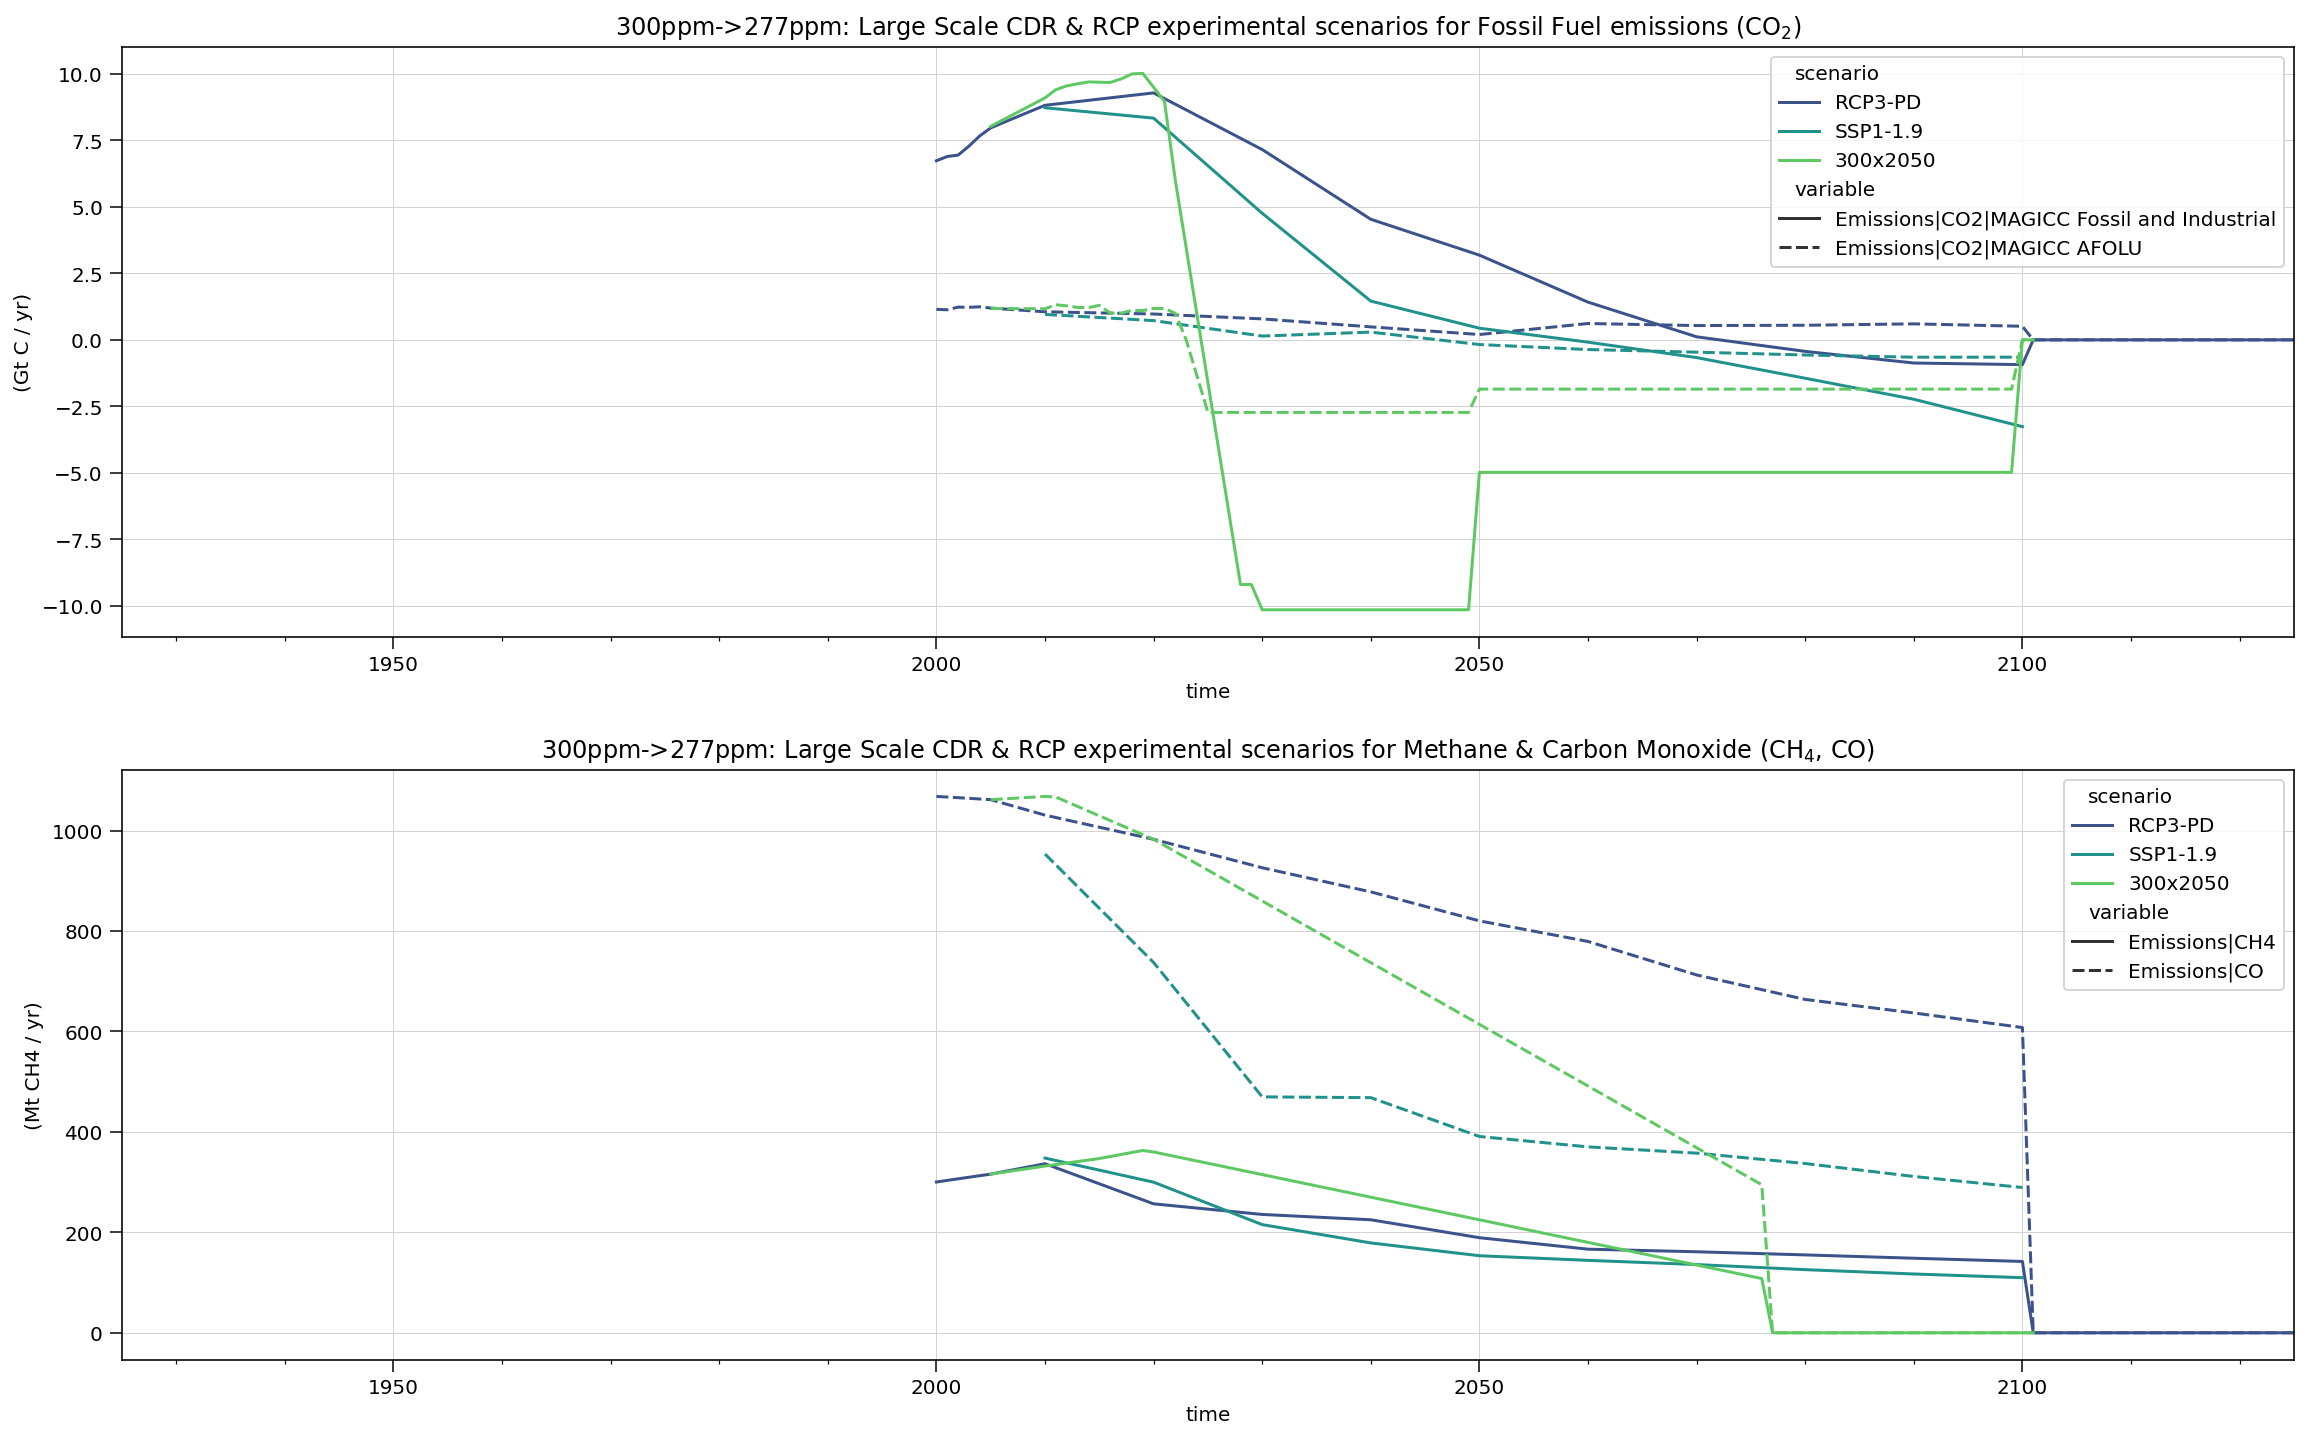

In [26]:
x = (datetime(2000, 1, 1), datetime(magcfg['endyear'], 1, 1))
pret='300ppm->277ppm: Large Scale CDR & RCP experimental scenarios for '
gtgvar = '*CO2|MAGICC Fossil and Industrial', '*CO2|MAGICC AFOLU*'
mtgvar = '*Emissions|CH4', '*Emissions|CO'
list = [gtgvar,mtgvar]
title = [pret + 'Fossil Fuel emissions (CO$_2$)', 
         pret + 'Methane & Carbon Monoxide (CH$_4$, CO)']

mdata = MAGICCData(rcp26)
#declines.append(CCCx2050)
#mdata = mdata.append(CCCx2050)
for scen in (img119, CCCx2050):
    mdata = mdata.append(scen)
fig, axes = plt.subplots(2,1, figsize = (16, 10))
for n,var in enumerate(list):
    varun = var[(n-1)]
    test = mdata.filter(region='World', variable=var).lineplot(hue='scenario', 
                        style='variable', ax=axes[n], palette='viridis')
    utils.ylabel = declines[0].filter(region='World', variable=varun)['unit'].iloc[[0]].all()
    utils.title = title[n]
    utils.plthelpr(axes[n],plt,profile='emiss')

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [27]:
pd.set_option('precision', 4)

In [28]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1
styr = zero_out_temp_start
eyr = zero_out_temp_end
selectftr = { 'region': 'World', 'variable': 'Surface Temperature',
             'year': range(magcfg['startyear'], magcfg['endyear']), }

#### Cache the meanbase line function.

In [29]:
# Mean baseline function

# Could be removed if the following can be reset in magcfg:
#   out_zero_temp_period = 1961, 1990
#   out_zero_heat_period = 1961, 1990
# check the literature if zero_heat_period should be moved in parallel.
    
def meanbln(scen,mgdata,**cfgs):
    pd.set_option('precision', 4)
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).sub(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [30]:
clvars = ['Surface Temperature']
nrvars = ['Radiative Forcing', 'Radiative Forcing|Greenhouse Gases|Kyoto Gases',
          'Radiative Forcing|Montreal Protocol Halogen Gases', 
          'Radiative Forcing|Aerosols|Indirect Effect', 
          'Radiative Forcing|Aerosols|Direct Effect', 'Radiative Forcing|Land-use Change',
          'Atmospheric Concentrations|CO2 Equivalent', 
          'Atmospheric Concentrations|CO2', 'Atmospheric Concentrations|N2O']
anthrovars = ['Emissions|CO2|MAGICC Fossil and Industrial', 'Emissions|CO2|MAGICC AFOLU']
cumulvar = [anthrovars[0]+'|Cumulative', anthrovars[1] + '|Cumulative']
addvars = ['SURFACE_ANNUALMEANTEMP', 'Surface Air Ocean Blended Temperature Change',
           'SURFACE_EQUILIBRIUMTEMP', 'HEATUPTAKE_EBALANCE_TOTAL', 
           'UPWELLING_RATE']
vars = clvars + nrvars + anthrovars + cumulvar + addvars + [ 'CLIMSENS_EFF' ]

In [31]:
notscen = ['MAGICC6','CDRex','not_relevant']
regionscen = notscen + [ c3x2050 ]
notscenlevels = ['climate_model','model','todo']
regionscenlevels = notscenlevels + ['scenario']
fullscen = regionscen + ['World']
fullscenlevels = regionscenlevels + ['region']

#### After helpers have been setup, run MAGICC

In [32]:
# Run Magicc & create results container for graphs.
#myscen = CCCx2050
#res = ''
#tmprs = pymagicc.run(myscen, **magcfg)
#res = meanbln(myscen, tmprs, **magcfg)

In [33]:
myscen = [ img119, CCCx2050 ]
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData

CPU times: user 3.39 s, sys: 203 ms, total: 3.6 s
Wall time: 10.4 s


In [34]:
for scen in myscen:
    tmprs = pymagicc.run(scen, **magcfg)
    res = res.append(meanbln(scen, tmprs, **magcfg))

In [35]:
#for scen in myscen:
#    res = res.append(pymagicc.run(scen, **magcfg))

In [36]:
scns = res['scenario'].unique()

#### Generate cumulative emissions graph timepoints

In [37]:
#sn=c3x2050
for sn in scns:
    for emis in anthrovars:
        cumurs = res.filter(scenario=sn, variable = emis).timeseries().cumsum(axis=1)
        cumurs = cumurs.rename(index={emis:emis+'|Cumulative'})
        cumurs = cumurs.rename(index={'Gt C / yr':'Cumulative Gt C'})
        res = res.append(cumurs)

### Graph MAGICC results
Note, graph zero axis is relative to 1720-1800 mean. Units remain in the native MAGICC format of Gt C, to convert multiply by 3.664 to change to Gt $CO_2$. Sharp decreases in temperature and radiative forcing are from volcanic activity. The sharpest dip is known as the Year of Poverty or No Summer in 1816.

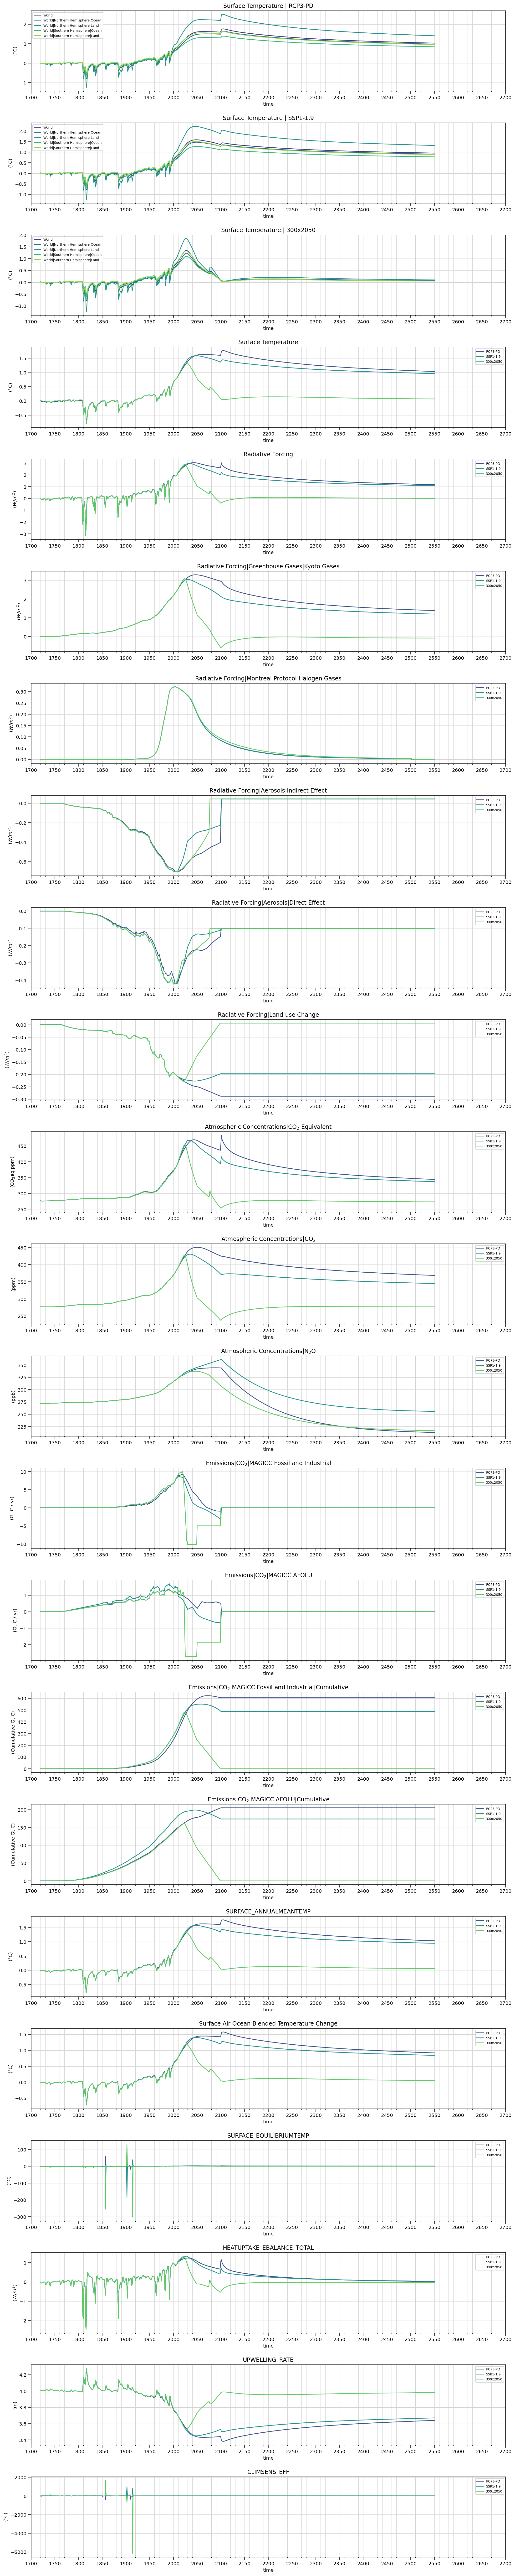

In [38]:
pts = len(vars)+len(scns) 

# Scale figures to 50 yrs per 1°C based on view
if view == 'pub':
    color = 'Greys'
    fig, axes = plt.subplots(pts, 1, figsize=(5.5, 75))
elif view == 'full':
    color = 'viridis'
    fig, axes = plt.subplots(pts, 1, figsize=(15, 75))

for n, scn in enumerate(scns):
    res.filter(variable=clvars, scenario=scn).lineplot(ax=axes[n], hue='region', palette='viridis')
    ftsize='x-small'
    axes[n].legend(loc='upper left', fontsize=ftsize)
    utils.ylabel = res.filter(variable=clvars)['unit'].iloc[[0]].all()
    utils.title = clvars[0] + ' | ' + scn
    utils.plthelpr(axes[n],plt,profile=view)

for n, var in enumerate(vars, start=(len(scns))):
    if view == 'pub':
        res.filter(variable=var, region='World').lineplot(ax=axes[n], style='scenario', palette=color)
    elif view == 'full':
        res.filter(variable=var, region='World').lineplot(ax=axes[n], hue='scenario', palette=color)
    ftsize='x-small'
    axes[n].legend(loc='best', fontsize=ftsize)
    utils.ylabel = res.filter(variable=var)['unit'].iloc[[0]].all()
    utils.title = var
    utils.plthelpr(axes[n],plt, profile=view)

#### Diagnostic Temperature Graphs

<AxesSubplot:title={'center':'Temperature Comparison'}, xlabel='Years', ylabel='$^{\\circ}$C'>

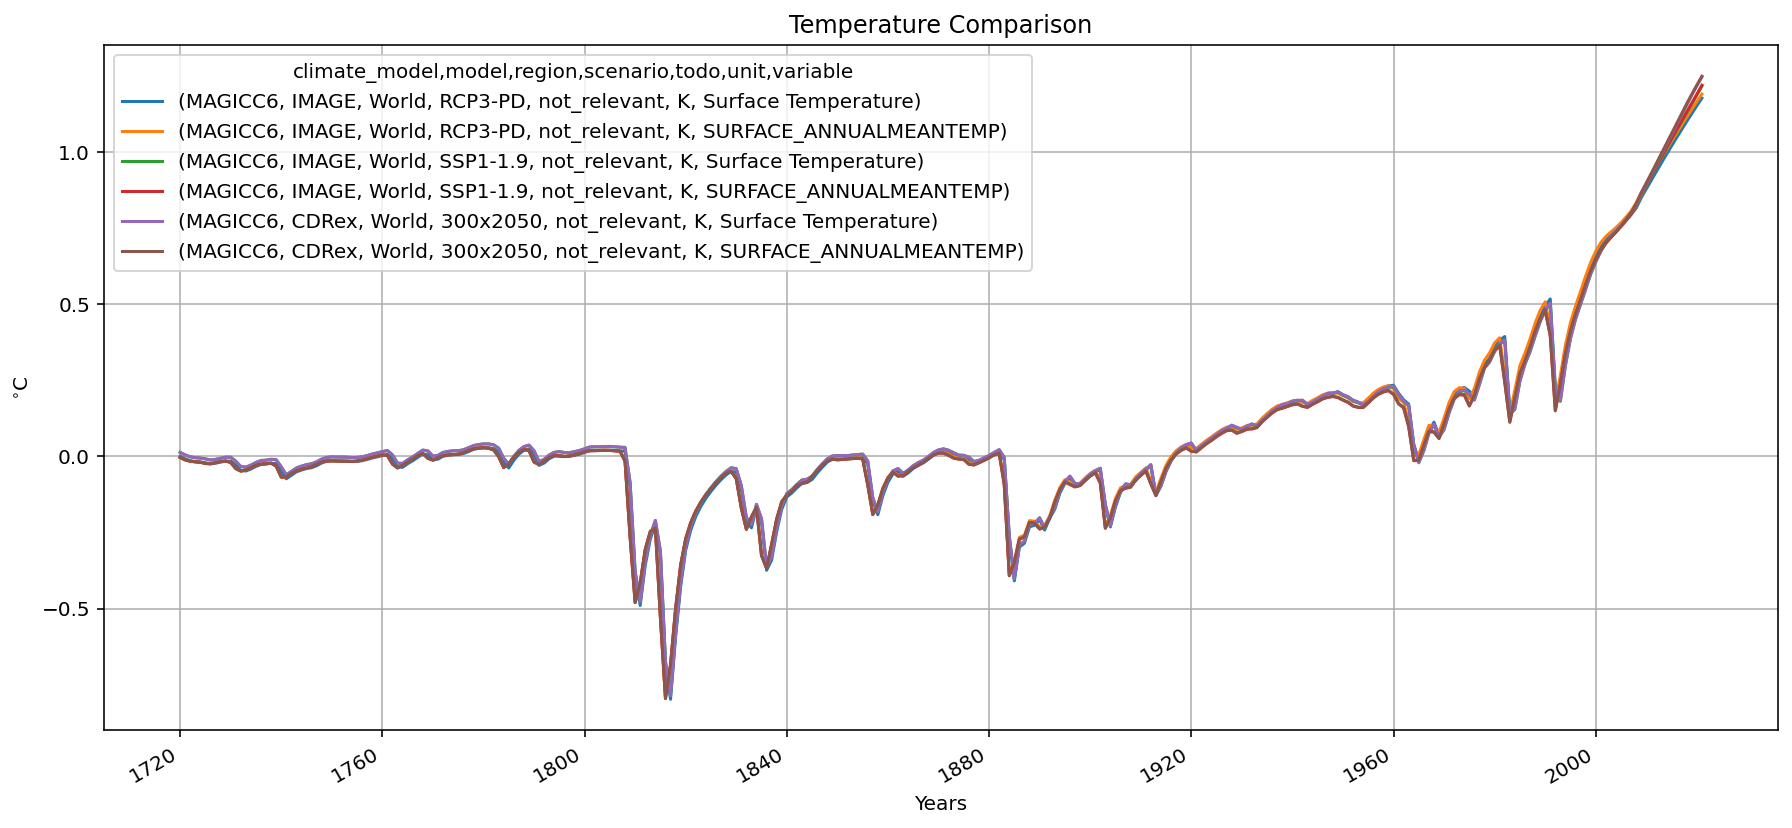

In [39]:
varz = ['SURFACE_ANNUALMEANTEMP', 'Surface Temperature']
slc = res.filter(variable=varz, 
                 region='World').timeseries().loc[:,datetime(1720,1,1):datetime(2021,1,1)]
slc.T.plot(figsize=(15,7), grid=True, ylabel = utils.degC, xlabel = 'Years', title='Temperature Comparison')

<AxesSubplot:title={'center':'RF & Aerosols'}, xlabel='Years', ylabel='$W / m^2$'>

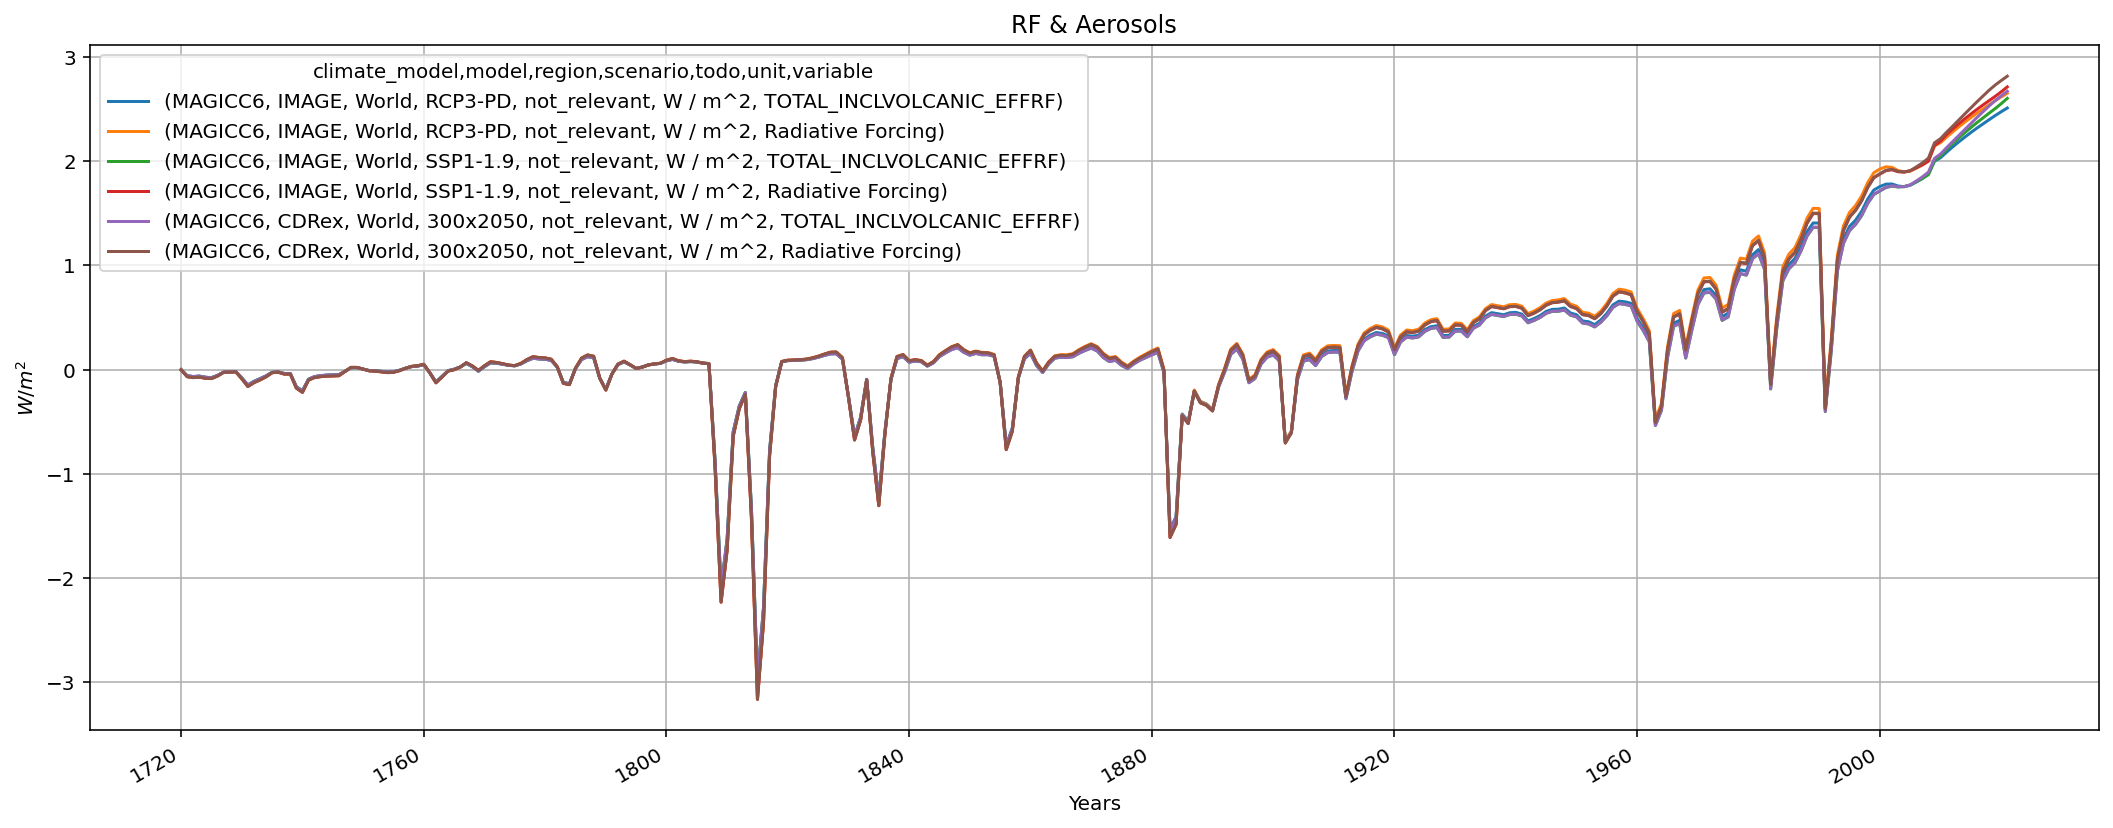

In [40]:
voltest = [ '*VOL*', 'Radiative Forcing' ]
slc = res.filter(variable=voltest, 
                 region='World').timeseries().loc[:,datetime(1720,1,1):datetime(2021,1,1)]
slc.T.plot(figsize=(18,7), grid=True, ylabel = utils.wm2, xlabel = 'Years', title='RF & Aerosols')

##### Pure volcanic radiative forcing comparison to identify global minimum caused by the Tambora volcanic eruption in 1815.

<AxesSubplot:title={'center':'RF'}, xlabel='Years', ylabel='$W / m^2$'>

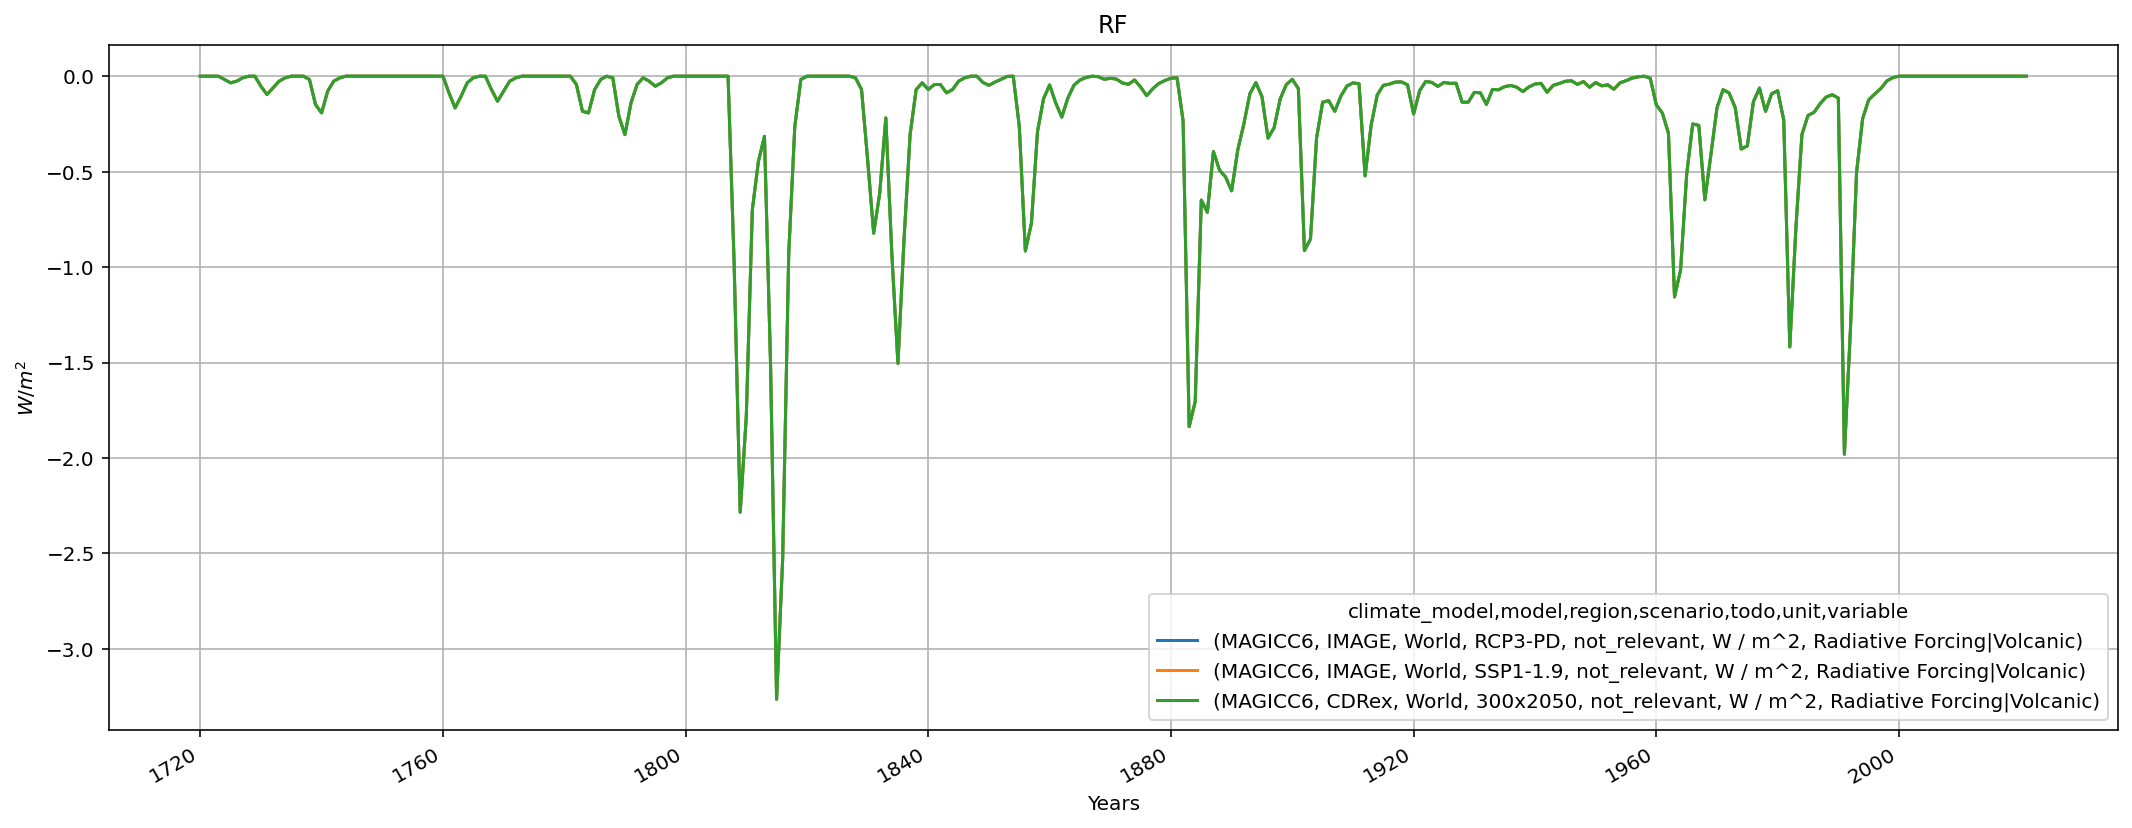

In [41]:
vartst = (['*olc*'])
slc = res.filter(variable=vartst, 
                 region='World').timeseries().loc[:,datetime(1720,1,1):datetime(2021,1,1)]
slc.T.plot(figsize=(18,7), grid=True, ylabel = utils.wm2, xlabel = 'Years', title='RF')


# Diagnostic Output
All diagnostics will only be performed on CDR experiment: 300 ppm by 2050, 300x2050 (CCCx2050), unless noted inline.

### Print $CO_2$ and Temperature Mean for the listed year timespans

In [42]:
mnbls = {
    'mean of 1720-1800': [ 1720, 1800 ],
    'mean of 1850-1900': [ 1850, 1900 ],
    'mean of 1861-1900': [ 1861, 1900 ],
    'mean of 1880-1900': [ 1880, 1900 ],
    'mean of 1951-1980': [ 1951, 1980 ], 
    'mean of 1961-1990': [ 1961, 1990 ]}

varwatch = ['Surface Temperature', 'SURFACE_ANNUALMEANTEMP','SURFACE_EQUILIBRIUMTEMP',
            'Atmospheric Concentrations|CO2', 
            'Atmospheric Concentrations|CO2 Equivalent']

midx = res.filter(scenario = c3x2050, variable = varwatch, 
                  region = 'World').timeseries().xs(fullscen, level = fullscenlevels)
mndf = pd.DataFrame(columns = mnbls.keys(), index = midx.index)

for key in mnbls.keys():
    # return span from cal years
    mydf = res.filter(scenario = c3x2050, variable = varwatch, region='World').timeseries().xs(fullscen, 
                level = fullscenlevels).loc[
                :,datetime(mnbls[key][0],1,1):datetime(mnbls[key][1],1,1)].T.mean()
    mndf[key] = mydf.values

mn1850 = mndf['mean of 1850-1900']
cmns = mndf['mean of 1961-1990'][1] + abs(mn1850[1])
t1850 = res.filter(scenario = c3x2050, variable = 'Surface Temperature', 
            region='World').timeseries().xs(fullscen, level = fullscenlevels).loc[
    :,datetime(1850,1,1)].values.squeeze()
print('\nTemperature at 1850 in {:.3f}°C relative to 1720-1800 mean.'.format(t1850))
print('The MAGICC generated difference from 1850-1900 to 1961-1990 is {:.4f}°C'.format(cmns))

mndf


Temperature at 1850 in 0.002°C relative to 1720-1800 mean.
The MAGICC generated difference from 1850-1900 to 1961-1990 is 0.2907°C


mean of 1720-1800  \
unit     variable                                                       
ppm      Atmospheric Concentrations|CO2                    2.7862e+02   
K        Surface Temperature                              -3.0411e-18   
         SURFACE_ANNUALMEANTEMP                           -1.2662e-02   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent         2.7830e+02   
K        SURFACE_EQUILIBRIUMTEMP                          -1.1298e-01   

                                                    mean of 1850-1900  \
unit     variable                                                       
ppm      Atmospheric Concentrations|CO2                      289.8765   
K        Surface Temperature                                  -0.0730   
         SURFACE_ANNUALMEANTEMP                               -0.0850   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent           285.3983   
K        SURFACE_EQUILIBRIUMTEMP                              -4.9182   

                                                    mean of 1861-1900  \
unit     variable                                                       
ppm      Atmospheric Concentrations|CO2                      291.0738   
K        Surface Temperature                                  -0.0805   
         SURFACE_ANNUALMEANTEMP                               -0.0914   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent           285.5798   
K        SURFACE_EQUILIBRIUMTEMP                               0.0511   

                                                    mean of 1880-1900  \
unit     variable                                                       
ppm      Atmospheric Concentrations|CO2                      293.9143   
K        Surface Temperature                                  -0.1440   
         SURFACE_ANNUALMEANTEMP                               -0.1546   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent           286.7767   
K        SURFACE_EQUILIBRIUMTEMP                              -0.0377   

                                                    mean of 1951-1980  \
unit     variable                                                       
ppm      Atmospheric Concentrations|CO2                      322.3647   
K        Surface Temperature                                   0.1753   
         SURFACE_ANNUALMEANTEMP                                0.1660   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent           312.4363   
K        SURFACE_EQUILIBRIUMTEMP                               0.2825   

                                                    mean of 1961-1990  
unit     variable                                                      
ppm      Atmospheric Concentrations|CO2                      333.5193  
K        Surface Temperature                                   0.2177  
         SURFACE_ANNUALMEANTEMP                                0.2105  
CO2eqppm Atmospheric Concentrations|CO2 Equivalent           326.4851  
K        SURFACE_EQUILIBRIUMTEMP                               0.3810

### Calculate Carbon Budget
Note, unlike nearly all other graphs in this workbook, the Carbon Budget graphs are relative to **1850-1900 mean**.

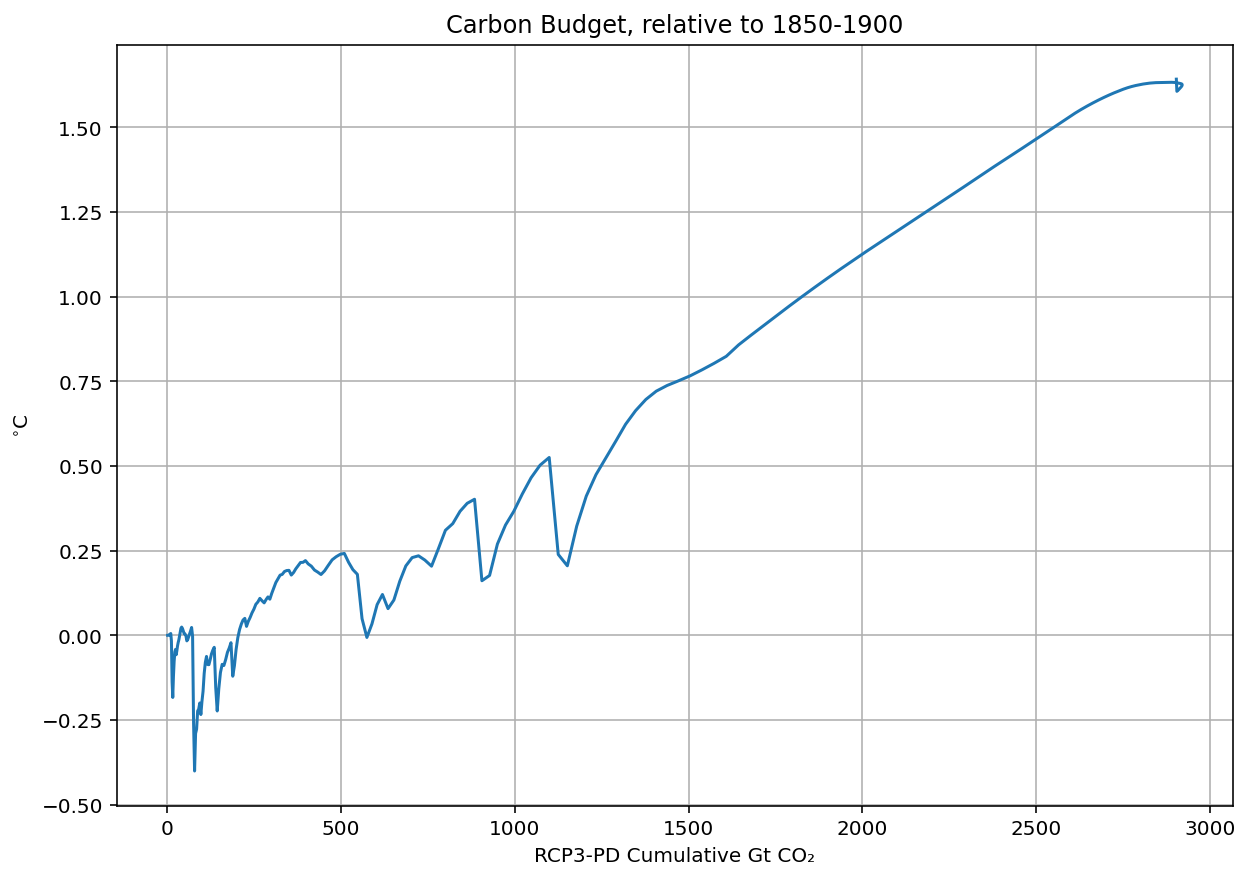

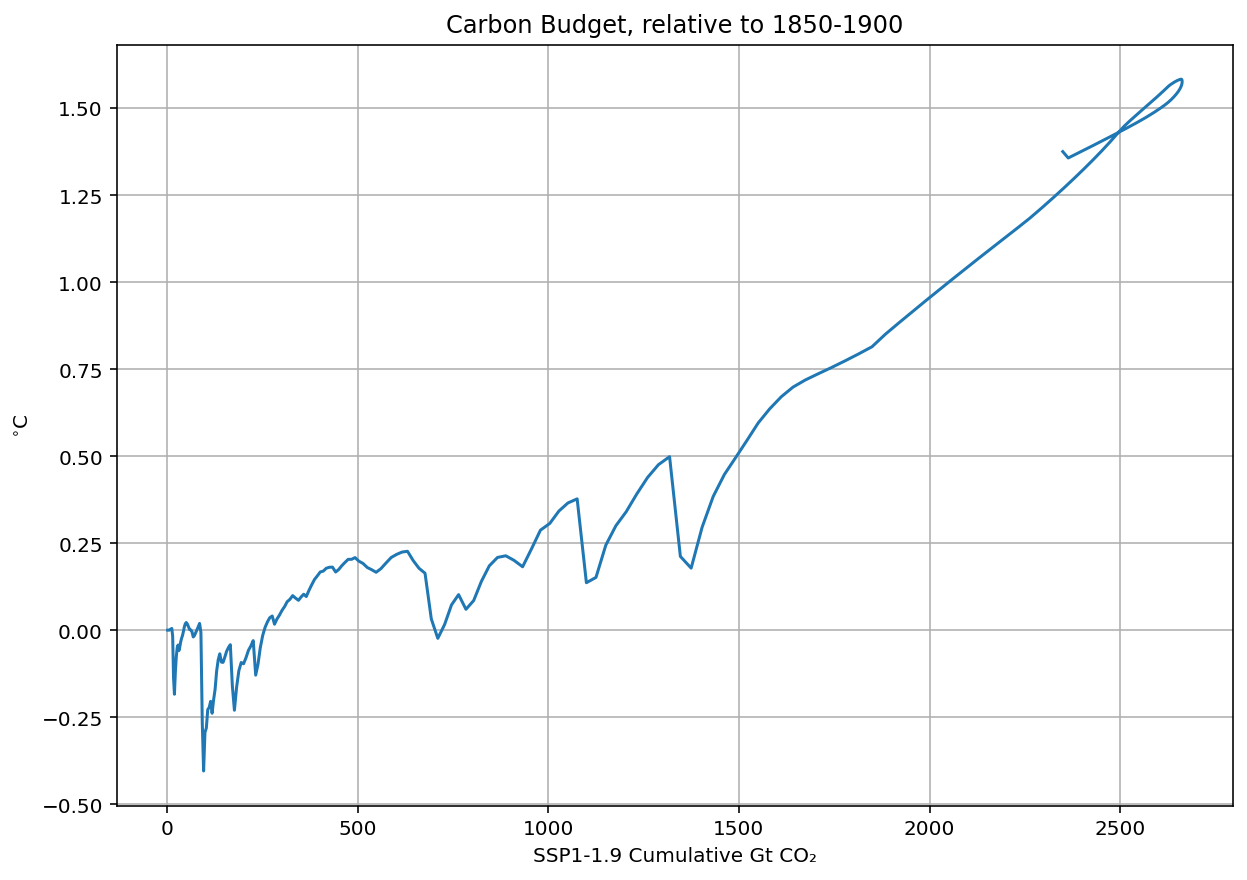

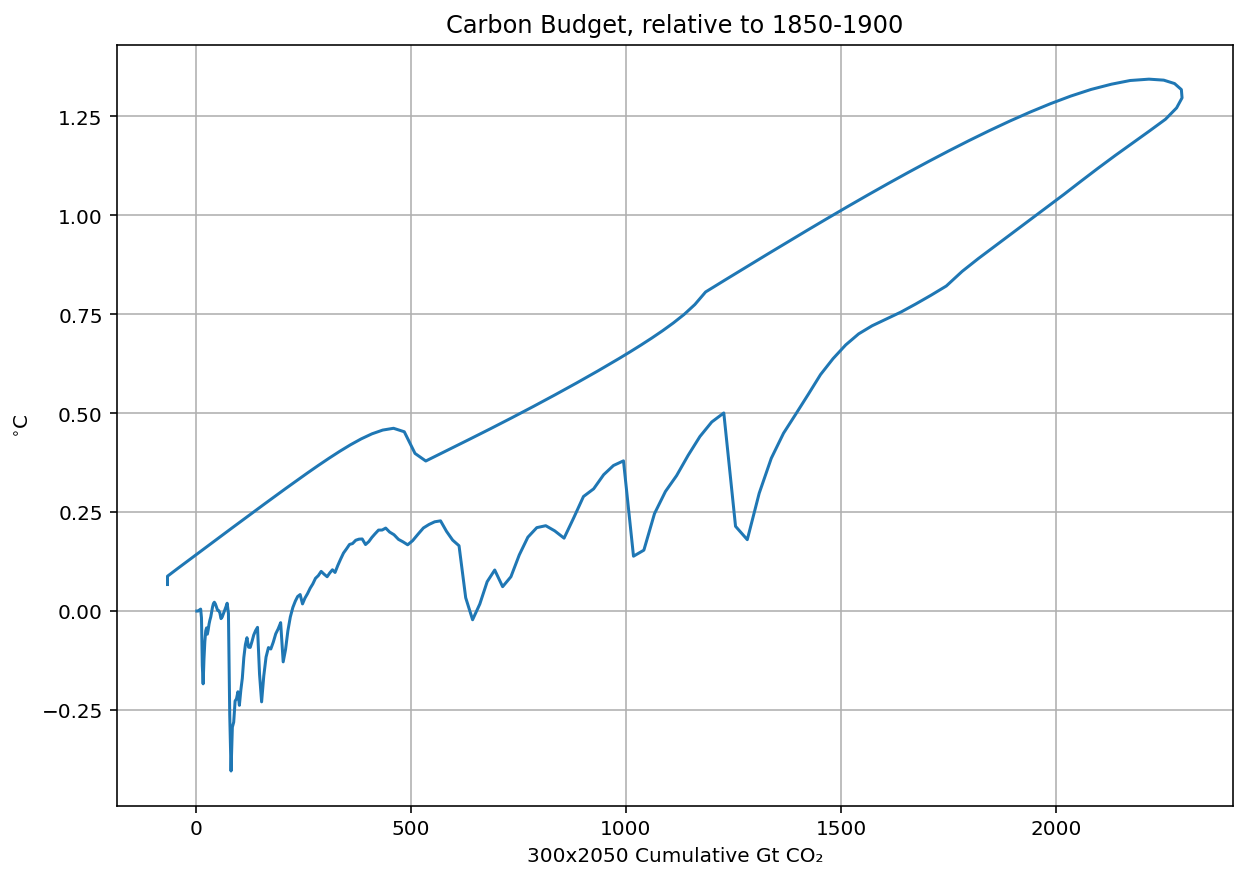

In [43]:
cb = pd.DataFrame()
times = [ (datetime(1850,1,1)), (datetime(2100,1,1)) ]

for thisscen in scns:
    t_1850 = res.filter(variable='Surface Temperature', region='World', 
            scenario = thisscen).timeseries().xs('not_relevant', level = 'todo').loc[:,times[0]]

    cb = res.filter(scenario=thisscen, variable = anthrovars, region='World'
            ).timeseries().xs('not_relevant', level = 'todo'
                             ).loc[:,times[0]:times[1]].cumsum(axis=1).multiply(3.664)
    cb.sub(cb.iloc[0])
    cb.iloc[0] = cb.iloc[0].add(cb.iloc[1])
    cb = cb.drop(index='Emissions|CO2|MAGICC AFOLU',level=5)
    cb = cb.rename(index={'Emissions|CO2|MAGICC Fossil and Industrial':'Cumulative GtCO₂'})
    cb = cb.rename(index={'Gt C / yr':'Gt CO₂ / yr'})
    cb = cb.append(res.filter(variable='Surface Temperature', region='World', 
            scenario = thisscen).timeseries().xs('not_relevant', level = 'todo'
                ).loc[:,times[0]:times[1]]).sub(t_1850[0])
    cb = cb.T
    cb.plot.line(x=0, y=1, figsize=(10,7), grid=True, legend=False, 
                 title="Carbon Budget, relative to 1850-1900", 
                 ylabel=utils.degC, xlabel=thisscen+' Cumulative Gt CO₂')

In [44]:
plt.close('all')

### MAGICC and HadCRUT5 comparison
Return the HadCRUT5 means for 1850-1900, and 1961-1990, and mean for the 2015-2020.
List MAGICC output for 2015-2020 with the 1850-1900 baseline in addition to the 1720-1800 baseline.

HadCRUT5 data from: An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research (Atmospheres), Morice, C.P., Kennedy, J.J., Rayner, N.A., Winn, J.P., Hogan, E., Killick, R.E., Dunn, R.J.H., Osborn, T.J., Jones, P.D., and Simpson, I.R., https://doi.org/10.1029/2019JD032361, https://crudata.uea.ac.uk/cru/data/temperature/

In [45]:
ev1850 = np.arange(0,100, 2) 
ev1961 = np.arange(222,280,2)
ev2015 = np.arange(330,340,2)
idxs = ['gl', 'nh', 'sh']
pdfs = {}
hd5df = pd.DataFrame( index = ['World', 'Northern Hemisphere', 'Southern Hemisphere' ],
            columns = ['H1850-1900', 'H1961-1990', 'H2015-2020', 'H2015-2020 1850', 'H2015-2020 1720'])
for n, st in enumerate (idxs):
    txt = join(SCEN_DIR,'HadCRUT5.0Analysis_'+st+'.txt')
    pdf = pd.read_fwf(txt,sep=' ', 
            names=['Year',1,2,3,4,5,6,7,8,9,10,11,12,'Ave']).xs(['Year','Ave'], axis=1, drop_level=False)
    pdfs[st] = pdf
    hd5df.iloc[n, 0] = pdf['Ave'][ev1850].T.mean()
    hd5df.iloc[n, 1] = pdf['Ave'][ev1961].T.mean()
    hd5df.iloc[n, 2] = pdf['Ave'][ev2015].T.mean()
    hd5df.iloc[n, 3] = hd5df.iloc[n, 2] + abs(hd5df.iloc[n, 0])
    hd5df.iloc[n, 4] = hd5df.iloc[n, 3] + mn1850[1]

tmm = res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).xs(['Surface Temperature','K'], 
        level=['variable', 'unit'],drop_level=True).loc[:,datetime(2015,1,1):datetime(2020,1,1)].T.mean()
cmm = tmm - mn1850[1]
mgd = pd.DataFrame(index = tmm.index, columns = ['1850-19mn','1720-18mn'])
mgd['1720-18mn'] = tmm.values
mgd['1850-19mn'] = cmm.values
hd5df['MG 1850'] = [cmm[0], ((mgd.iloc[1]['1850-19mn']+mgd.iloc[2]['1850-19mn'])/2), 
                     ((mgd.iloc[3]['1850-19mn']+mgd.iloc[4]['1850-19mn'])/2) ]
hd5df['MG 1720'] = [tmm[0], ((mgd.iloc[1]['1720-18mn']+mgd.iloc[2]['1720-18mn'])/2),
                     ((mgd.iloc[3]['1720-18mn']+mgd.iloc[4]['1720-18mn'])/2) ]
hd5df['mg ∆ 1850'] = hd5df['H2015-2020 1850'] - hd5df['MG 1850']
hd5df['mg ∆ 1720'] = hd5df['H2015-2020 1720'] - hd5df['MG 1720']
print('HadCRUT5 Temperature Means listed in the calendar year.')
hd5df.style

HadCRUT5 Temperature Means listed in the calendar year.


,H1850-1900,H1961-1990,H2015-2020,H2015-2020 1850,H2015-2020 1720,MG 1850,MG 1720,mg ∆ 1850,mg ∆ 1720
World,-0.3589,-0.0046,0.8514,1.2103,1.1373,1.2095,1.1365,0.0009,0.0009
Northern Hemisphere,-0.3709,-0.0150,1.1210,1.4919,1.4190,1.3668,1.2938,0.1251,0.1251
Southern Hemisphere,-0.3470,0.0059,0.5818,0.9288,0.8558,1.1057,1.0327,-0.1769,-0.1769


In [46]:
mgd.sort_values(by=['1850-19mn'],ascending=False)

,1850-19mn,1720-18mn
region,,
World|Northern Hemisphere|Land,1.6357,1.5627
World,1.2095,1.1365
World|Southern Hemisphere|Land,1.2090,1.1360
World|Northern Hemisphere|Ocean,1.0979,1.0249
World|Southern Hemisphere|Ocean,1.0024,0.9294


### Return the lowest temperature in the time-series

In [47]:
rts = res.timeseries()

scen, df = utils.finddate('Surface Temperature', 'min', rts, c3x2050, 1720)
print(scen)
df

300x2050


time                                        1817-01-01
model region                          unit            
CDRex World                           K        -0.7863
      World|Northern Hemisphere|Ocean K        -0.6939
      World|Northern Hemisphere|Land  K        -1.2383
      World|Southern Hemisphere|Ocean K        -0.5619
      World|Southern Hemisphere|Land  K        -0.7475

### Return the lowest temperature after 2005

In [48]:
#scen, df = utils.finddate('Surface Temperature', 'min', rts, c3x2050, 2005)
#print(scen)
#df

### Return the highest temperature until the series end in the 2600s

In [49]:
scen, df = utils.finddate('Surface Temperature', 'max', rts, c3x2050)
print(scen)
yr = df.columns[0]
df.sort_values(yr,ascending=False)

300x2050


time                                        2026-01-01  2027-01-01
model region                          unit                        
CDRex World|Northern Hemisphere|Land  K         1.8522      1.8508
      World                           K         1.3440      1.3465
      World|Southern Hemisphere|Land  K         1.3237      1.3253
      World|Northern Hemisphere|Ocean K         1.2241      1.2282
      World|Southern Hemisphere|Ocean K         1.0950      1.0993

### Return the peak temperatures for all series till 2100

In [50]:
#for scen in scns:
#    for v in varwatch:
#        scen, df = utils.finddate(v, 'max', rts, scen, 2010)
#        print(scen)
#        print(df)

### Detail warming including calibration points of 2015-2020, and peak timeframe 2027-2028 to a 1720-1800 baseline.

In [51]:
res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).loc[:,datetime(2013,1,1):datetime(2039,1,1)].style

,,time,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2026-01-01 00:00:00,2027-01-01 00:00:00,2028-01-01 00:00:00,2029-01-01 00:00:00,2030-01-01 00:00:00,2031-01-01 00:00:00,2032-01-01 00:00:00,2033-01-01 00:00:00,2034-01-01 00:00:00,2035-01-01 00:00:00,2036-01-01 00:00:00,2037-01-01 00:00:00,2038-01-01 00:00:00,2039-01-01 00:00:00
region,unit,variable,,,,,,,,,,,,,,,,,,,,,,,,,,,
World,K,Surface Temperature,0.9897,1.0224,1.0551,1.0881,1.1208,1.1536,1.1854,1.2158,1.2454,1.2739,1.2993,1.3202,1.3354,1.3440,1.3465,1.3431,1.3337,1.3205,1.3038,1.2846,1.2634,1.2407,1.2167,1.1916,1.1656,1.1387,1.1111
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.8880,0.9184,0.9489,0.9796,1.0102,1.0408,1.0707,1.0994,1.1272,1.1540,1.1784,1.1988,1.2143,1.2241,1.2282,1.2270,1.2203,1.2098,1.1960,1.1797,1.1614,1.1417,1.1206,1.0985,1.0754,1.0514,1.0267
World|Northern Hemisphere|Land,K,Surface Temperature,1.3408,1.3905,1.4403,1.4904,1.5400,1.5897,1.6363,1.6797,1.7221,1.7628,1.7980,1.8259,1.8444,1.8522,1.8508,1.8403,1.8208,1.7965,1.7672,1.7350,1.7004,1.6640,1.6260,1.5867,1.5463,1.5049,1.4627
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.8203,0.8444,0.8687,0.8931,0.9174,0.9417,0.9660,0.9897,1.0127,1.0350,1.0554,1.0727,1.0862,1.0950,1.0993,1.0992,1.0947,1.0869,1.0763,1.0634,1.0488,1.0329,1.0157,0.9976,0.9786,0.9589,0.9385
World|Southern Hemisphere|Land,K,Surface Temperature,1.0059,1.0348,1.0638,1.0929,1.1218,1.1506,1.1794,1.2074,1.2347,1.2609,1.2840,1.3029,1.3164,1.3237,1.3253,1.3215,1.3122,1.2994,1.2834,1.2650,1.2449,1.2234,1.2006,1.1769,1.1522,1.1268,1.1006


### Show $CO_2$ concentration for calibration 2015-2020

In [52]:
res.filter(variable = 'Atmospheric Concentrations|CO2*').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2015,1,1):datetime(2022,1,1)]

time                                                         2015-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 407.1283   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      423.2610   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             467.4113   

time                                                         2016-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 410.0336   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      427.8149   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             471.3090   

time                                                         2017-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 412.7757   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      432.2309   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             475.0229   

time                                                         2018-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 415.5564   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      436.7212   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             478.7855   

time                                                         2019-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 418.4511   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      440.9353   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             482.6842   

time                                                         2020-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 421.3218   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      444.7494   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             486.5610   

time                                                         2021-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 423.9704   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      448.4346   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             490.1046   

time                                                         2022-01-01 00:00:00  
unit     variable                                                                 
ppm      Atmospheric Concentrations|CO2                                 426.3728  
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      451.7697  
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             493.2666

In [53]:
#DEBUG STUB
res.filter(variable = 'Atmospheric Concentrations|CO2', region='World', 
           scenario = c3x2050).timeseries().loc[:,datetime(2020,1,1,0)].sub(
    res.filter(variable = 'Atmospheric Concentrations|CO2', region='World', 
        scenario = c3x2050).timeseries().loc[:,datetime(2015,1,1,0)])

climate_model  model  region  scenario  todo          unit  variable                      
MAGICC6        CDRex  World   300x2050  not_relevant  ppm   Atmospheric Concentrations|CO2    14.1935
dtype: float64

### Show $CO_2$ concentration, radiative forcing and surface temperature at 2020, 2100, and 2550.

In [54]:
dts = [ datetime(2020,1,1,0), datetime(2100,1,1,0), datetime(magcfg['endyear'],1,1,0)]
res.filter(variable = ['Atmospheric Concentrations|CO2', 'Radiative Forcing', 'Surface Temperature'], 
           region='World', scenario=['SSP1-1.9', c3x2050 ]).timeseries().loc[:,dts]

time                                                                                     2020-01-01 00:00:00  \
climate_model model region scenario todo         unit    variable                                              
MAGICC6       IMAGE World  SSP1-1.9 not_relevant ppm     Atmospheric Concentrations|CO2             415.8408   
                                                 W / m^2 Radiative Forcing                            2.6656   
                                                 K       Surface Temperature                          1.1856   
              CDRex World  300x2050 not_relevant ppm     Atmospheric Concentrations|CO2             421.3218   
                                                 W / m^2 Radiative Forcing                            2.7738   
                                                 K       Surface Temperature                          1.2158   

time                                                                                     2100-01-01 00:00:00  \
climate_model model region scenario todo         unit    variable                                              
MAGICC6       IMAGE World  SSP1-1.9 not_relevant ppm     Atmospheric Concentrations|CO2             371.8397   
                                                 W / m^2 Radiative Forcing                            2.0874   
                                                 K       Surface Temperature                          1.3773   
              CDRex World  300x2050 not_relevant ppm     Atmospheric Concentrations|CO2             237.3759   
                                                 W / m^2 Radiative Forcing                           -0.4094   
                                                 K       Surface Temperature                          0.0692   

time                                                                                     2550-01-01 00:00:00  
climate_model model region scenario todo         unit    variable                                             
MAGICC6       IMAGE World  SSP1-1.9 not_relevant ppm     Atmospheric Concentrations|CO2             344.8451  
                                                 W / m^2 Radiative Forcing                            1.0784  
                                                 K       Surface Temperature                          0.9568  
              CDRex World  300x2050 not_relevant ppm     Atmospheric Concentrations|CO2             278.8180  
                                                 W / m^2 Radiative Forcing                            0.0068  
                                                 K       Surface Temperature                          0.0674

### Show $CO_2$ concentration during peak carbon.

In [55]:
res.filter(variable = 'Atmospheric Concentrations|CO2*').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2022,1,1):datetime(2028,1,1)]

time                                                         2022-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 426.3728   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      451.7697   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             493.2666   

time                                                         2023-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 427.3552   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      453.5959   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             494.6935   

time                                                         2024-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 426.8265   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      453.8360   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             494.2842   

time                                                         2025-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 424.6686   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      452.3032   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             491.9074   

time                                                         2026-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 420.9375   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      448.9968   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             487.6346   

time                                                         2027-01-01 00:00:00  \
unit     variable                                                                  
ppm      Atmospheric Concentrations|CO2                                 416.2994   
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      444.6178   
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             482.2315   

time                                                         2028-01-01 00:00:00  
unit     variable                                                                 
ppm      Atmospheric Concentrations|CO2                                 410.7636  
CO2eqppm Atmospheric Concentrations|CO2 Equivalent                      439.1826  
         Atmospheric Concentrations|CO2 Equivalent|Kyoto...             475.7180

### Show years after CR to see how temperature responds.

In [56]:
res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).loc[:,datetime(2101,1,1):datetime(2107,1,1)].style

,,time,2101-01-01 00:00:00,2102-01-01 00:00:00,2103-01-01 00:00:00,2104-01-01 00:00:00,2105-01-01 00:00:00,2106-01-01 00:00:00,2107-01-01 00:00:00
region,unit,variable,,,,,,,
World,K,Surface Temperature,0.0577,0.0514,0.0476,0.0456,0.0446,0.0444,0.0449
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.0669,0.0600,0.0556,0.0530,0.0515,0.0508,0.0507
World|Northern Hemisphere|Land,K,Surface Temperature,0.0420,0.0368,0.0345,0.0342,0.0352,0.0370,0.0394
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.0668,0.0601,0.0556,0.0527,0.0508,0.0497,0.0491
World|Southern Hemisphere|Land,K,Surface Temperature,0.0424,0.0368,0.0334,0.0316,0.0307,0.0306,0.0310


### Diagnostic Summary Tables

In [57]:
#print(vars)

In [58]:
pd.set_option('precision', 4)
dbdates = [ datetime(1750,1,1,0), datetime(1816,1,1,0), datetime(1817,1,1,0), datetime(1850,1,1,0), 
            datetime(2099,1,1,0), datetime(2100,1,1,0), datetime(2101,1,1,0) ]
dates = dbdates + [ datetime(2023,1,1,0), datetime(2024,1,1,0), datetime(2050,1,1,0), datetime(2082,1,1,0),  
        datetime(magcfg['endyear'],1,1,0) ]
temps = ['Surface Temperature', 'SURFACE_ANNUALMEANTEMP']

myvars = temps+['Radiative Forcing', 'Atmospheric Concentrations|CO2' ]

#strs = (res.filter(variable = vars, region='World').timeseries().loc[:,dates])
strs = (res.filter(variable = myvars, region='World').timeseries().loc[:,dates])
strs = strs.xs(['MAGICC6','World','not_relevant'], level = ['climate_model','region','todo'], 
               drop_level=True)
lmdts = res.filter(variable = vars, region='World').timeseries().xs(
    ['MAGICC6','World','not_relevant'], level = ['climate_model','region','todo'], 
    drop_level=True).loc[:,datetime(2082,1,1,0):datetime(2101,1,1,0)].mean(1)

strs['2081-2100 mean'] = lmdts

for n, tmps in enumerate (temps):
    lmdst = lmdts.xs([tmps], level = ['variable'], drop_level=False).add(abs(mn1850[n+1]))
    strs.loc[lmdst.index,'2081-2100 1850mn'] = lmdst

strs.loc[:,dates + ['2081-2100 mean', '2081-2100 1850mn']]
#strs.style.set_properties(**{'background-color': '#ddffff'}, 
#        subset=[datetime(2100,1,1,0), datetime(magcfg['endyear'],1,1,0), '2081-2100 1850mn'])

time                                                   1750-01-01 00:00:00  \
model scenario unit    variable                                              
IMAGE RCP3-PD  ppm     Atmospheric Concentrations|CO2             277.0147   
               W / m^2 Radiative Forcing                            0.0052   
               K       Surface Temperature                         -0.0150   
                       SURFACE_ANNUALMEANTEMP                      -0.0151   
      SSP1-1.9 ppm     Atmospheric Concentrations|CO2             277.0147   
               W / m^2 Radiative Forcing                            0.0052   
               K       Surface Temperature                         -0.0022   
                       SURFACE_ANNUALMEANTEMP                      -0.0151   
CDRex 300x2050 ppm     Atmospheric Concentrations|CO2             277.0147   
               W / m^2 Radiative Forcing                            0.0052   
               K       Surface Temperature                         -0.0022   
                       SURFACE_ANNUALMEANTEMP                      -0.0151   

time                                                   1816-01-01 00:00:00  \
model scenario unit    variable                                              
IMAGE RCP3-PD  ppm     Atmospheric Concentrations|CO2             284.0643   
               W / m^2 Radiative Forcing                           -2.4181   
               K       Surface Temperature                         -0.6850   
                       SURFACE_ANNUALMEANTEMP                      -0.7944   
      SSP1-1.9 ppm     Atmospheric Concentrations|CO2             284.0643   
               W / m^2 Radiative Forcing                           -2.4195   
               K       Surface Temperature                         -0.6731   
                       SURFACE_ANNUALMEANTEMP                      -0.7953   
CDRex 300x2050 ppm     Atmospheric Concentrations|CO2             284.0643   
               W / m^2 Radiative Forcing                           -2.4196   
               K       Surface Temperature                         -0.6732   
                       SURFACE_ANNUALMEANTEMP                      -0.7954   

time                                                   1817-01-01 00:00:00  \
model scenario unit    variable                                              
IMAGE RCP3-PD  ppm     Atmospheric Concentrations|CO2             284.1080   
               W / m^2 Radiative Forcing                           -0.8223   
               K       Surface Temperature                         -0.7980   
                       SURFACE_ANNUALMEANTEMP                      -0.6839   
      SSP1-1.9 ppm     Atmospheric Concentrations|CO2             284.1080   
               W / m^2 Radiative Forcing                           -0.8238   
               K       Surface Temperature                         -0.7862   
                       SURFACE_ANNUALMEANTEMP                      -0.6849   
CDRex 300x2050 ppm     Atmospheric Concentrations|CO2             284.1080   
               W / m^2 Radiative Forcing                           -0.8239   
               K       Surface Temperature                         -0.7863   
                       SURFACE_ANNUALMEANTEMP                      -0.6849   

time                                                   1850-01-01 00:00:00  \
model scenario unit    variable                                              
IMAGE RCP3-PD  ppm     Atmospheric Concentrations|CO2             284.8000   
               W / m^2 Radiative Forcing                            0.1627   
               K       Surface Temperature                         -0.0086   
                       SURFACE_ANNUALMEANTEMP                      -0.0096   
      SSP1-1.9 ppm     Atmospheric Concentrations|CO2             284.8000   
               W / m^2 Radiative Forcing                            0.1587   
               K       Surface Temperature                          0.0021   
                   

In [59]:
#res.filter(variable=['*VOL*', '*Concentrations|CO2*', '*Emissions|CO2|*', 'Surface Temperature', 
#                     'SURFACE_ANNUALMEANTEMP'], region='World', 
#           scenario='RCP3-PD').timeseries().loc[:,datetime(1721,1,1,0):datetime(1766,1,1,0)].style

#### Verify all cumulative emissions are removed

In [60]:
pd.set_option('precision', 16)
res.filter(variable='Emissions|CO2|MAGICC*Cumulative', region='World').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2101,1,1)]

unit             variable                                             
Cumulative Gt C  Emissions|CO2|MAGICC Fossil and Industrial|Cumulative    0.0000944183001810
                 Emissions|CO2|MAGICC AFOLU|Cumulative                   -0.0021904478002441
Name: 2101-01-01 00:00:00, dtype: float64

In [61]:
gcbmagcal()

Mag is: 444.2601 207.9211
GCB FF->2024: 482.43, GCB LUC->2024: 204.38
AnthroC is 482.83, LuC is 162.16280955219977


In [62]:
pd.set_option('precision', 4)

In [63]:
CCC_df.iloc[:2,:].loc[:,datetime(2005,1,1):datetime(2030,1,1)].style


### Show maximum and minimum $CO_2$ concentration and Surface Temperature post 2100.

In [64]:
varwatch = ('Atmospheric Concentrations|CO2', 'Surface Temperature')
mydf = []
ddf = pd.DataFrame()
for myvar in varwatch:
    for func in ('max', 'min'):
        scen, mydf = utils.finddate(myvar, func, res.filter(region='World', scenario=c3x2050).timeseries(), c3x2050, 2100 )
        mydf = mydf.xs(['World', 'CDRex'], level = ['region', 'model'], drop_level=True)
        rows = np.append(mydf.index.values, myvar)
        rwhdr = np.append(mydf.index.names, 'variable')
        midx = pd.MultiIndex.from_frame(pd.DataFrame([rows], columns=rwhdr))
        ddf = ddf.append(pd.DataFrame(mydf.values, columns=mydf.columns, index=midx))
ddf

time                                 2100-01-01 00:00:00  2106-01-01 00:00:00  \
unit variable                                                                   
ppm  Atmospheric Concentrations|CO2                  NaN                  NaN   
     Atmospheric Concentrations|CO2             237.3759                  NaN   
K    Surface Temperature                             NaN                  NaN   
     Surface Temperature                             NaN               0.0444   

time                                 2212-01-01 00:00:00  2549-01-01 00:00:00  \
unit variable                                                                   
ppm  Atmospheric Concentrations|CO2                  NaN              278.818   
     Atmospheric Concentrations|CO2                  NaN                  NaN   
K    Surface Temperature                          0.1426                  NaN   
     Surface Temperature                             NaN                  NaN   

time                                 2550-01-01 00:00:00  
unit variable                                             
ppm  Atmospheric Concentrations|CO2              278.818  
     Atmospheric Concentrations|CO2                  NaN  
K    Surface Temperature                             NaN  
     Surface Temperature                             NaN

##### Show Detected Climate Sensitivity minimum and maximum data

In [65]:
csres = res.filter(region='World', scenario=c3x2050).timeseries()
scen, csdf = utils.finddate('CLIMSENS_EFF', 'min', csres, c3x2050, 2100)
csdf

,,time,2103-01-01
model,region,unit,
CDRex,World,K,1.2708


In [66]:
scen, csdf = utils.finddate('CLIMSENS_EFF', 'max', csres, c3x2050, 2100)
csdf

,,time,2550-01-01 00:00:00
model,region,unit,
CDRex,World,K,3.8327


### Debugging Output
Uncomment and run to obtain details for specific problematic gasses.

In [67]:
for glob in 'Land-use', 'Mineral Dust', 'Indirect', '143a', 'HCFC22', '141b', 'Halon1301':
    debugdf = res.filter(region='World', 
                        variable='*' + glob + '*').timeseries().xs([
                    'MAGICC6','CDRex','not_relevant','World',c3x2050], 
                    level = ['climate_model','model','todo','region','scenario']).loc[:,datetime(2005,1,1):datetime(2662,1,1)]
    #print('Min is {},\nMax is {}'.format(debugdf.T.min(), debugdf.T.max()))
#Radiative Forcing|Aerosols|Direct Effect|Mineral Dust .0003
#debugdf.style
debugdf

,time,2005-01-01 00:00:00,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,2009-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,...,2541-01-01 00:00:00,2542-01-01 00:00:00,2543-01-01 00:00:00,2544-01-01 00:00:00,2545-01-01 00:00:00,2546-01-01 00:00:00,2547-01-01 00:00:00,2548-01-01 00:00:00,2549-01-01 00:00:00,2550-01-01 00:00:00
unit,variable,,,,,,,,,,,,,,,,,,,,,
W / m^2,Radiative Forcing|Halon1301,0.0009,0.0009,0.001,0.001,0.0010,0.0010,0.0010,0.0010,0.0010,0.001,...,3.9991e-07,3.9381e-07,3.8780e-07,3.8187e-07,3.7604e-07,3.7030e-07,3.6465e-07,3.5908e-07,3.5360e-07,3.5360e-07
ppt,Atmospheric Concentrations|Halon1301,2.9260,2.9590,2.988,3.013,3.0286,3.0407,3.0493,3.0546,3.0568,3.056,...,1.2497e-03,1.2306e-03,1.2119e-03,1.1934e-03,1.1751e-03,1.1572e-03,1.1395e-03,1.1221e-03,1.1050e-03,1.1050e-03


In [68]:
voltest = ['*VOL*', '*olc*','*SOx*', '*Temperature*', '*ANNUALMEANTEMP*', '*EQ*']
res.filter(region='World', variable=voltest).timeseries().xs(
    ['MAGICC6','CDRex','not_relevant','World',c3x2050], 
    level = ['climate_model','model','todo','region','scenario']).loc[:,datetime(1814,1,1):datetime(1823,1,1)].style

In [69]:
#dfdebug2050 = res.filter(region='World', scenario=c3x2050).timeseries().xs([
#    'MAGICC6','CDRex','World',c3x2050,'not_relevant'], 
#    level = ['climate_model','model','region','scenario','todo'])
#newdf = dfdebug2050.loc[ 
#        (dfdebug2050[ datetime(2662,1,1,0)] > 0.00001) ]
#newdf.loc[:,datetime(2200,1,1,0):datetime(2300,1,1,0)].sort_index().style

In [70]:
# What's causing that bounce back where as the 
# rest of the graph is decreasing?
# Uncomment this block and run. It will show
# a stack of gasses that are increasing due to 
# definations in WMO2006_ODS_A1Baseline.prn
# The dates of the growth moves based on stFF

dfdebug2050 = res.filter(
    scenario=c3x2050,region='World').timeseries().xs([
    'MAGICC6','CDRex','World',c3x2050,'not_relevant'], 
    level = ['climate_model','model','region','scenario','todo'])
newdf = dfdebug2050.loc[ (dfdebug2050[ datetime(stFF-3,1,1,0)] < dfdebug2050[datetime(stFF,1,1,0)]) & (dfdebug2050[ datetime(2100,1,1,0)] > 0) ]
newdf.loc[:,datetime(stFF-3,1,1,0):datetime(stFF+10,1,1,0)].sort_index().style

In [71]:
# Dump all possible variables
#res.filter(variable='*', scenario=['SSP1-1.9',c3x2050], region='World').timeseries().loc[:,[datetime(1720,1,1,0),datetime(2500,1,1,0)]].sort_index().style

#### Basic Climate Sensitivity Fitting Exercise

This uses the MAGICC temperature data relative to 1720-1800 mean and $CO_2$ concentration to extrapolate a curve scaled to identify the temperature at one doubling of $CO_2$. If we continue to emitt exponentally, it will drive $CO_2$ concentration exponetially upward and temperature as well.

Note, $CO_2$ measured atmospheric concentrations in blue doesn't move, only temperature in respect to core_sensitivity. The fitting execrcise is to show how closely temperatures match both estimated sensitivty and HadCRUT5 (2021) analysis.

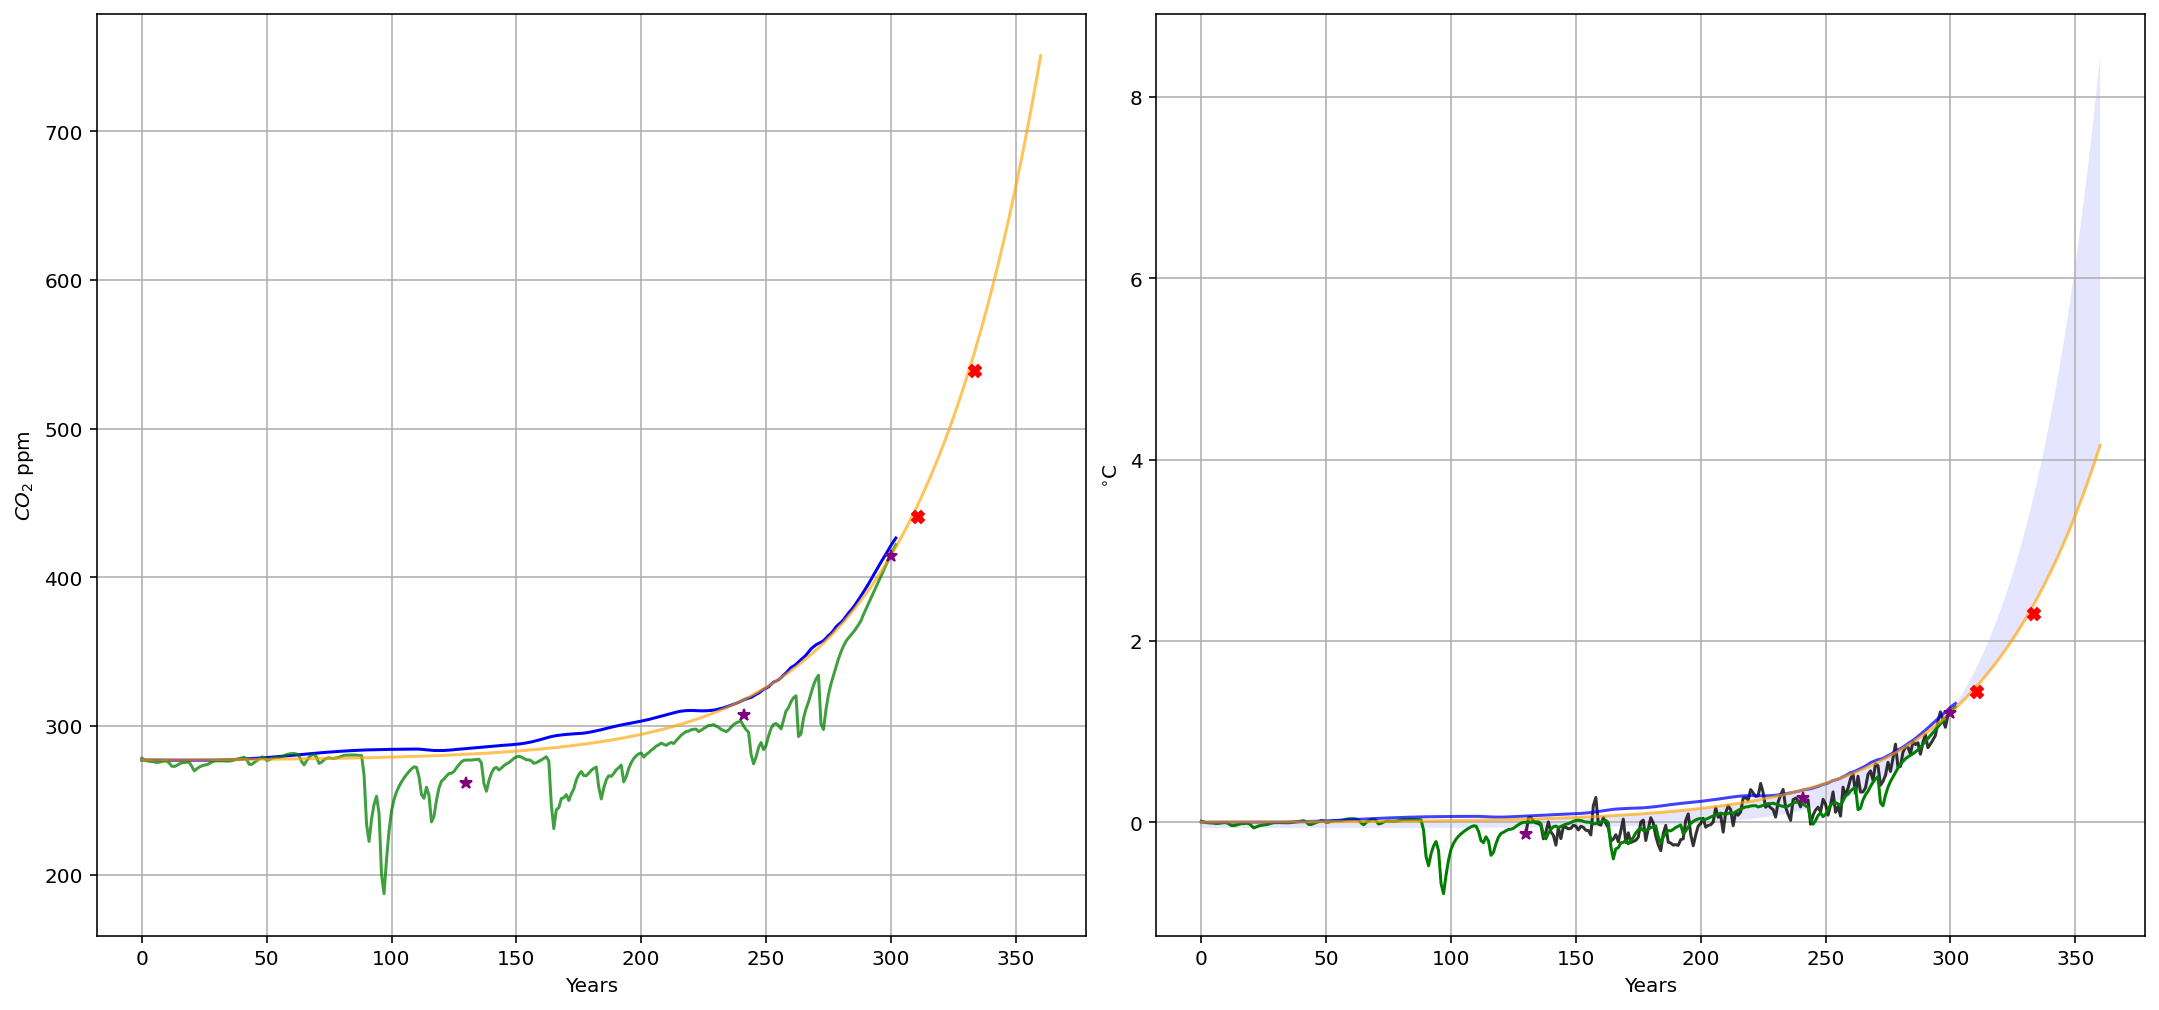

Years are internal MAGICC years unless listed otherwise, subtract 1 from the year to convert to calendar year.
Red Xes at 450 and 552 ppm.


,0,97,130,241,300
dates,1720.0000,1817.0000,1850.0000,1961.0000,2020.0000
CO2,277.0000,284.1080,284.8000,317.4600,421.3218
Temperature,0.0128,-0.7863,0.0022,0.2036,1.2158


In [72]:
from scipy.optimize import curve_fit
def exp_fit(x, a, b, c):
    y = a*np.exp(b*x) + c
    return y

myvars = ['Atmospheric Concentrations|CO2', 'Surface Temperature']
# HadCRUT5 Global Temperature for 1850, 1961, 2020, based around the mean of 1961-1990
hadCRUT5 = [-0.418, -0.020, 0.922]      #hadCRUT5 GL, cal yr, 1961-1990 baseline
mhd = hadCRUT5 + abs(hd5df.iloc[0, 0])  #hadCRUT5 GL, cal yr, 1850-1900 baseline
mmhd = mhd + mn1850[1]   #hadCRUT5 GL, cal yr, relative to 1720-1800
hd52020 = pdfs['gl']['Ave'].dropna().values + abs(hd5df.iloc[0,0]) + mn1850[1]
hdvals = np.arange(130,301)

xvals = np.arange(303)
dfco2 = res.filter(variable = myvars[0], region='World', scenario=c3x2050).timeseries()
dftemp = res.filter(variable = myvars[1], region='World', scenario=c3x2050).timeseries()
offset = res.filter(variable = myvars[1], region='World', scenario=c3x2050).timeseries().columns[0]
yrset = offset.year
yrco2ppm = dfco2.values.squeeze()[:303]
yrtemp = dftemp.values.squeeze()[:303]
popts = (.2715, .0206, 276.744)
topts = (114)
sc = 1.2
tsttmp, tstcov = curve_fit(exp_fit, xvals, yrtemp, p0=[popts[0]/topts, popts[1], 0])
co2fit = exp_fit(xvals*sc, *popts)
tempfit = exp_fit(xvals*sc, popts[0]/topts, popts[1], 0)
tempfit2 = exp_fit(xvals*sc, *tsttmp)

idxyr = [259, 278]
cpts = [co2fit[idxyr[0]], co2fit[idxyr[1]]]
tpts = [tempfit[idxyr[0]], tempfit[idxyr[1]]]
extdf = pd.DataFrame()
extdf['dates'] = xvals+yrset
extdf['CO2'] = yrco2ppm
extdf['Temperature'] = yrtemp
extdf = extdf.T
scdf = pd.DataFrame()
scdf['dates|extrapolate'] = (xvals[0:301])*sc+yrset
scdf['CO2|extrapolate'] = co2fit[2:303]
scdf['Temperature|extrapolate'] = tempfit[2:303]
scdf['Temperature|extrapolate2'] = tempfit2[0:301]
scdf = scdf.T
dts = [ 0, 1817-yrset, 1850-yrset, 1961-yrset, -3 ]
sdts = [ 0, 1850/sc-yrset/sc, 2021/sc-yrset/sc, 2023/sc-yrset/sc, 2032/sc-yrset/sc, 
        2033/sc-yrset/sc, 2055/sc-yrset/sc, 2056/sc-yrset/sc ]
prt = extdf.iloc[:,dts]
sprt = scdf.iloc[:,sdts]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
ax1.plot(xvals, yrco2ppm, color = 'blue')
ax1.plot(xvals, (topts*yrtemp)+popts[2], color = 'green', alpha=.75)
ax1.plot(xvals[0:301]*sc, scdf.iloc[1], color = 'orange', alpha=.65)
ax1.plot(xvals[[130,241,300]], (topts*mmhd)+popts[2], '*' , color = 'purple')
ax1.plot([xvals[idxyr[0]]*sc, xvals[idxyr[1]]*sc], cpts, 'X', color = 'red')
ax1.set_xlabel('Years'), ax1.set_ylabel('$CO_2$ ppm')
ax1.grid()
ax2.plot(hdvals, hd52020, color = 'black', alpha=.80)
ax2.plot(xvals, yrtemp, color = 'green')
ax2.plot(xvals, (1/topts*yrco2ppm)-popts[2]/topts, color = 'blue', alpha=.75)
ax2.plot(xvals[0:301]*sc, scdf.iloc[2], color = 'orange', alpha=.65)
ax2.plot(xvals[[130,241,300]], mmhd, '*' , color = 'purple')
ax2.plot([xvals[idxyr[0]]*sc, xvals[idxyr[1]]*sc], tpts, 'X', color = 'red')
ax2.fill_between(xvals[0:301]*sc, scdf.iloc[2], scdf.iloc[3], facecolor='blue', alpha=.10)
ax2.set_xlabel('Years'), ax2.set_ylabel(utils.degC)
ax2.grid()
plt.tight_layout(pad=0.6, h_pad=1.5)
plt.show()
print('Years are internal MAGICC years unless listed otherwise, subtract\
 1 from the year to convert to calendar year.\nRed Xes at 450 and 552 ppm.')
plt.close('all')
prt.style

In [73]:
sprt

,0,108,250,252,260,260,279,280
dates|extrapolate,1720.0000,1849.6000,2020.0000,2022.4000,2032.0000,2032.0000,2054.8000,2056.0000
CO2|extrapolate,277.0293,280.8622,414.5224,421.5054,453.1604,453.1604,558.9188,565.9811
Temperature|extrapolate,0.0025,0.0361,1.2086,1.2698,1.5475,1.5475,2.4752,2.5372
Temperature|extrapolate2,-0.0621,-0.0564,1.2098,1.3104,1.7986,1.7986,3.7710,3.9196


In [74]:
print('HadCRUT5 and the following uses the calendar year.')
print('HadCRUT5, 1961-1990 mean | 1850 {}°C,  1961 {}°C,  2020 {}°C'.format(hadCRUT5[0],hadCRUT5[1],hadCRUT5[2]))
print('HadCRUT5, 1850-1900 mean | 1850 {:.4f}°C, 1961 {:.4f}°C, 2020 {:.4f}°C'.format(mhd[0],mhd[1],mhd[2]))
print('HadCRUT5+MAGICC, 1750-1800 mean | 1850 {:.4f}°C, 1961 {:.4f}°C, 2020 {:.4f}°C\n'.format(mmhd[0],mmhd[1],mmhd[2]))
print('2x CO₂ is 276.744*2 = {} ppm.'.format(276.744*2))
print('Fit1 {:.4f} ppm, {:.3f}°C predicted at year {:.0f}.'.format(scdf.iloc[1, 278], 
        scdf.iloc[2, 278], 278*sc+yrset-2))
print('Fit2 {:.4f} ppm, {:.3f}°C predicted at year {:.0f}.'.format(scdf.iloc[1, 278], 
        scdf.iloc[3, 278], 278*sc+yrset-2))

HadCRUT5 and the following uses the calendar year.
HadCRUT5, 1961-1990 mean | 1850 -0.418°C,  1961 -0.02°C,  2020 0.922°C
HadCRUT5, 1850-1900 mean | 1850 -0.0591°C, 1961 0.3389°C, 2020 1.2809°C
HadCRUT5+MAGICC, 1750-1800 mean | 1850 -0.1321°C, 1961 0.2659°C, 2020 1.2079°C

2x CO₂ is 276.744*2 = 553.488 ppm.
Fit1 552.0290 ppm, 2.415°C predicted at year 2052.
Fit2 552.0290 ppm, 3.628°C predicted at year 2052.


### Display detected Equlibrium Climate Sensitivity, Transient Climate Response, Transient Climate Response to cumulative Emissions

Caculate the ECS, TCR, TCRE values for both the positive and negative emissions. Calculations based off of abrupt-2xCO2, 1pctCO2, and abrupt-0p5xCO2, 1pctCO2-cdr CMIP6 and CDRMIP experiments, and the current MAGICC settings from magcfg. Non relevant magcfg settings are ignored.

1pctCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=74a0936a-68d6-4c5b-8acc-ac9f31c8a8bd&version=1&client=esdoc-search

abrupt-2xCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=af20c84a-35b1-4b5a-9013-3039390c286e&version=1&client=esdoc-search

1pctCO2-cdr: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=6a465822-ac43-4b3e-beb4-388d291860d4&version=1&client=esdoc-search

abrupt-0p5xCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=8ff7a328-e031-49f1-862c-68be2c5648e8&version=1&client=esdoc-search

In [75]:
mcfg = magcfg.copy()
sitv = mcfg['core_climatesensitivity']
print("MAGICC ECS setting: {} K, MAGICC ∆Q2xCO2 setting: {} k".format(sitv, mcfg['core_delq2xco2']))
for test in 'pos', 'neg':
    resultsdata = utils.diagnose_tcr_ecs_tcre(test, 
        CORE_CLIMATESENSITIVITY=sitv,
        CORE_DELQ2XCO2=mcfg['core_delq2xco2'], **magcfg)
    print("TCR is {tcr:.4f}, ECS is {ecs:.4f} and TCRE is {tcre[0]:.6f} {tcre[1]}".format(
                **resultsdata))

MAGICC ECS setting: 3.257 K, MAGICC ∆Q2xCO2 setting: 3.71 k
Calculating ECS from abrupt-2xCO2.
Calculating TCR & TCRE from 1pctCO2.
TCR is 2.0882, ECS is 3.2376 kelvin and TCRE is 2.420048 kelvin / 1000 GtC
Calculating ECS from abrupt-0p5xCO2.
Calculating TCR & TCRE from 1pctCO2-cdr.
TCR is 2.0882, ECS is 3.2555 kelvin and TCRE is 2.420048 kelvin / 1000 GtC


### Display temperature response with custom sensitivities over the entire time-series.
The default climate sensitivity is set to 3.45 K, which allows a tuned model output to roughly match the HadCRUT5 global temperature mean for the years 2015-2020.

#### Setup sensitivities for the last graph

In [76]:
lsitv = (sitv - 1.15)
lsitv = float('{:1.4}'.format(lsitv))
hsitv = (sitv + 1.15)
hsitv = float('{:1.4}'.format(hsitv))
runs = {'default': sitv, 'low': lsitv, 'high': hsitv }

In [77]:
# Pull the sensitivites defined in runs.
myscenario = CCCx2050
runsdf = {}

def calc_msensi(runs, myscenario):
    for rn in runs:
        mcfg['core_climatesensitivity'] = runs[rn]
        newrn = pymagicc.run(myscenario, **mcfg)
        runsdf[rn] = meanbln(myscenario, newrn, **mcfg)
    return(runsdf)

runsdf = calc_msensi(runs, myscenario)

In [78]:
filtering = {'variable': 'Surface Temperature', 
             'year': range(1720, magcfg['endyear'])}

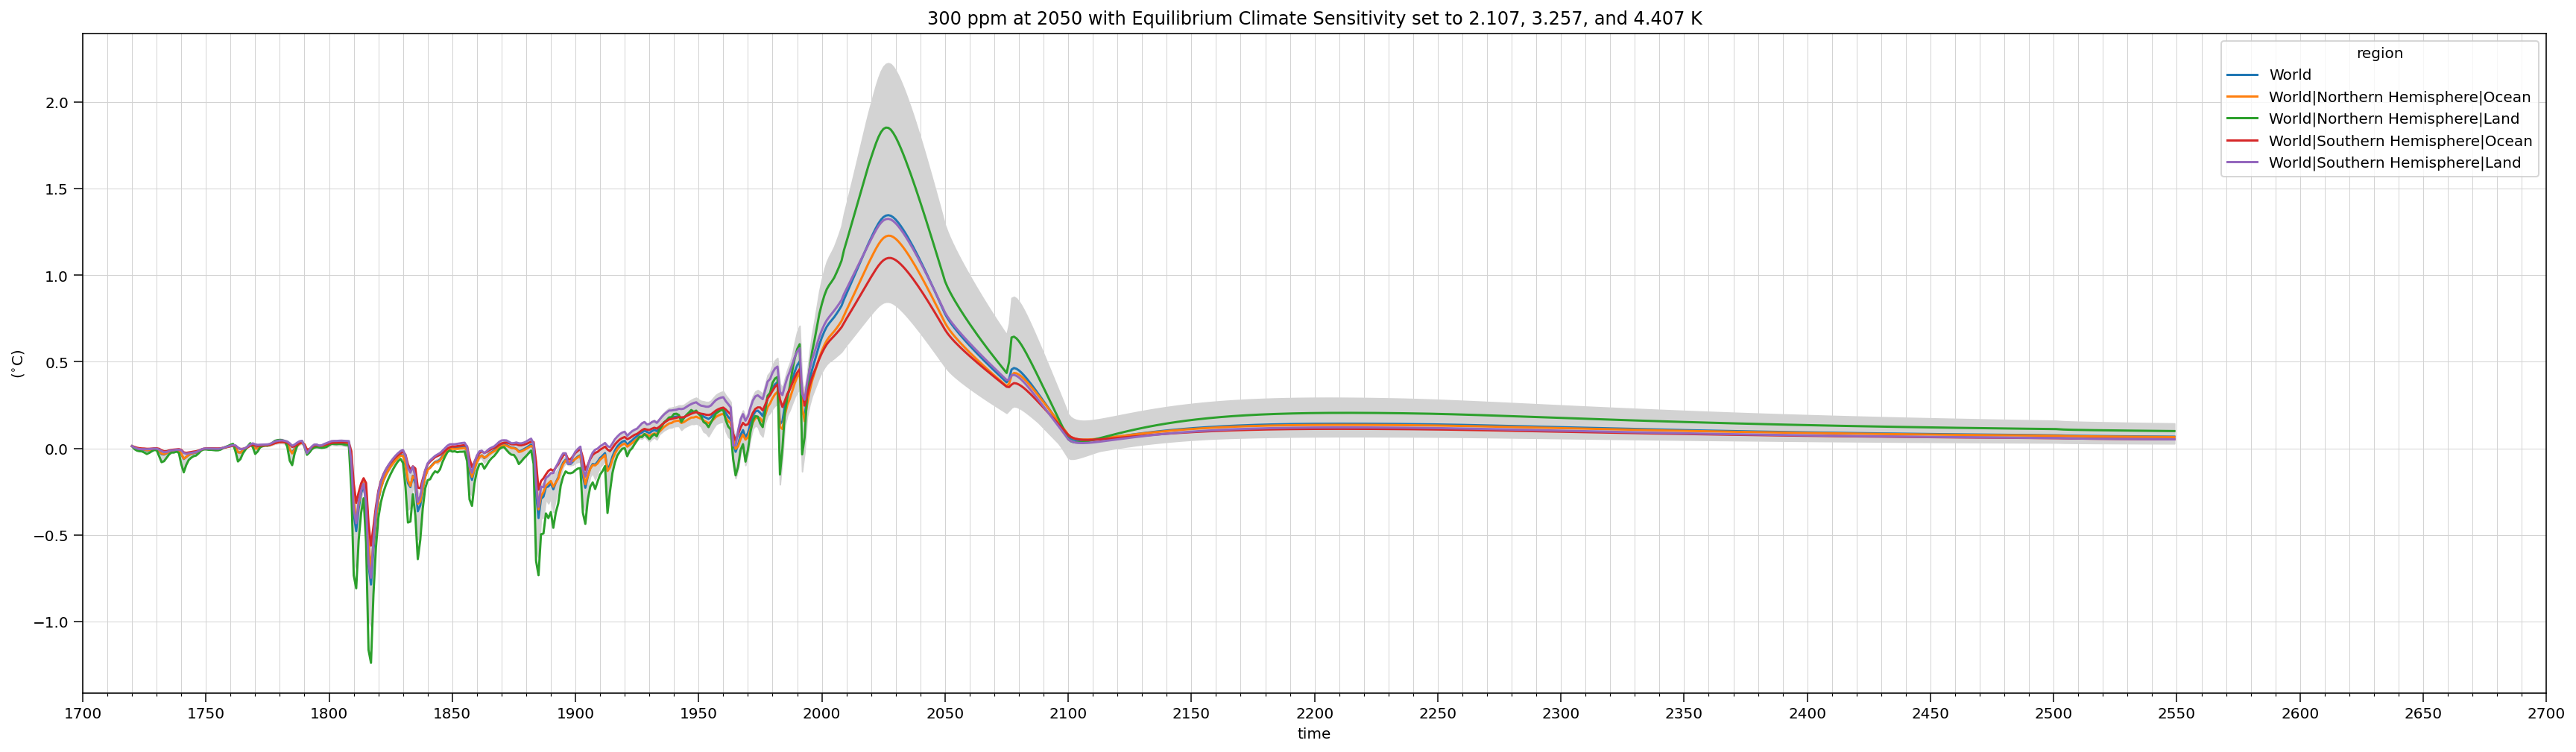

In [79]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(24, 7))
runsdf['default'].filter(**filtering).lineplot( x='time', ax=ax, hue='region')
plt.fill_between(
    runsdf['default'].filter(**filtering, region='World')['time'],
    runsdf['low'].filter(**filtering).timeseries().min().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().max().values.squeeze(),
    color='lightgray',
)
utils.title = (f'300 ppm at 2050 with Equilibrium Climate Sensitivity\
 set to {lsitv}, {sitv}, and {hsitv} K')
utils.ylabel = utils.degC;
utils.plthelpr(ax,plt,profile='full')

-----
-----

## Funding
Anonymous sponsor retired from semiconductor manufacturing, software entrepreneur, @timmo, US economic stimulus. Funding goal has not been met, consider sponsoring: https://github.com/sponsors/safiume.

## References

Open NanoCarbon CDRMEx Project page: https://opennanocarbon.atlassian.net/wiki/spaces/REF/pages/575963137/Method+to+Determine+A+CDR+Target

Pymagicc: A Python wrapper for the simple climate model MAGICC. Journal of Open Source Software, 3(22), 516, Gieseke, R., Willner, S. N. and Mengel, M. (2018), https://doi.org/10.21105/joss.00516

MAGICC6, Emulating coupled atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 1: Model description and calibration, Meinshausen, M., Raper, S., Wigley, T., (2011), https://doi.org/10.5194/acp-11-1417-2011

Emulating atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 2: Applications, Meinshausen, M., Raper, S., Wigley, T., (2011), https://doi.org/10.5194/acp-11-1457-2011

Scientific assessment of ozone depletion: 2006. Global ozone research and monitoring project Report No. 50. Geneva, Switzerland, World Meteorological Organization: 572, Chapter 8; & Butler et al. 1999, 

A record of atmospheric halocarbons during the twentieth century from polar firn air, Butler, J., Battle, M., Bender, M., Montzka, S., Clarke, A. D., Saltzman, E. S., Sucher, C. M., Severinghaus, J. P., Elkins, J. W., Nature volume 399, pages 749–755 (1999), https://doi.org/10.1038/21586

Estimating Changes in Global Temperature since the Preindustrial Period, Hawkins, E., Ortega, P., Suckling, E., Schurer, A., Hegerl, G., Jones, P., Joshi, M., Osborn, T., Masson-Delmotte, V., Mignot, J., Thorne P., Oldenborgh, G., (2017), https://doi.org/10.1175/BAMS-D-16-0007.1

Assessment Modeling Consortium & International Institute for Applied Systems Analysis, Huppmann, D., Kriegler, E., Krey, V., Riahi, K., Rogelj, J., Rose, S., Weyant, J., et al., (2018),
https://doi.org/10.22022/SR15/08-2018.15429

IAMC 1.5°C Scenario Explorer and Data hosted by IIASA, https://data.ene.iiasa.ac.at/iamc-1.5c-explorer,  https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/#/license

Scenarios towards limiting global mean temperature increase below 1.5 °C, Rogelj, J., Popp, A., Calvin, K. V. et al., Nature Climate Change 8, 325–332 (2018), https://doi.org/10.1038/s41558-018-0091-3

Global Carbon Budget 2020, Friedlingstein, P. et al., (2020), https://doi.org/10.18160/GCP-2020 

HadCRUT5 data from: An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research (Atmospheres), Morice, C., Kennedy, J., Rayner, N., Winn, J., Hogan, E., Killick, R., Dunn, R., Osborn, T., Jones, P., Simpson, I., (2020), https://doi.org/10.1029/2019JD032361 https://crudata.uea.ac.uk/cru/data/temperature/

Reduced Complexity Model Intercomparison Project Phase 1: introduction and evaluation of global-mean temperature response, Nicholls, Z., Meinshausen, M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., Fan, C., Fuglestvedt, J., Gasser, T., Golüke, U., Goodwin, P., Hartin, C., Hope, A., Kriegler, E., Leach, N., Marchegiani, D., McBride, L., Quilcaille, Y., Rogelj, J., Salawitch, R., Samset, B., Sandstad, M., Shiklomanov, A., Skeie, R., Smith, C., Smith, S., Tanaka, K., Tsutsui, J., Xie, Z., (2020), https://doi.org/10.5194/gmd-13-5175-2020

Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization, Eyring, V., Bony, S., Meeh, G., Senior, C., Stevens, B., Stouffer, R., Taylor, K., https://doi.org/10.5194/gmd-9-1937-2016

CMIP6 model data is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (https://creativecommons.org/licenses/). https://pcmdi.llnl.gov/CMIP6/TermsOfUse

The Carbon Dioxide Removal Model Intercomparison Project (CDR-MIP): Rationale and experimental protocol for CMIP6, Keller, D. P., Lenton, A., Scott, V., Vaughan, N. E., Bauer, N., Ji, D., Jones, C. D., Kravitz, B., Muri, H., Zickfeld, K. (2018), https://doi.org/10.5194/gmd-11-1133-2018